<a href="https://colab.research.google.com/github/neuromatch/NeuroAI_Course/blob/main/tutorials/W2D3_Microlearning/student/W2D3_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/tutorials/W2D3_Microlearning/student/W2D3_Tutorial1.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Tutorial 1: Microlearning

**Week 2, Day 3: Microlearning**

**By Neuromatch Academy** 

__Content creators:__ Blake Richards, Roman Pogodin, Daniel Levenstein, Colin Bredenberg, Jonathan Cornford

__Content reviewers:__ Aakash Agrawal, Alish Dipani, Hossein Rezaei, Yousef Ghanbari, Mostafa Abdollahi, Samuele Bolotta, Patrick Mineault, Hlib Solodzhuk

__Production editors:__ Konstantine Tsafatinos, Ella Batty, Spiros Chavlis, Samuele Bolotta, Hlib Solodzhuk

___

# Tutorial Objectives

*Estimated timing of tutorial: 2 hours*

In this tutorial, you will learn about normative models of synaptic plasticity. Normative models of synaptic plasticity are learning rules for parameters in neural networks that have two important features:

  * They optimize global objective functions that define behavioral/perceptual goals for an agent.

  * Unlike learning algorithms like backpropagation, they demonstrate how learning is 'local', i.e. it uses only information that could conceivably be available to a single synapse.

These two features together make such learning algorithms good candidate models for how learning could work in the brain.

In this tutorial, we will:

* Relate local plasticity rules to estimates of loss gradients.
* Understand the impact of variance and bias in gradient estimators and how they affect the scalability, performance, and generalization capabilities of learning algorithms.
* Implement 2-3 learning rules in toy tasks.
* Describe issues with biological plausibility in some learning algorithms, most notably, weight transport.

In [ ]:
# @title Tutorial slides
# @markdown These are the slides for the videos in all tutorials today

from IPython.display import IFrame
from ipywidgets import widgets
out = widgets.Output()

link_id = "rx89q"

with out:
    print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
    display(IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render", width=730, height=410))
display(out)

# Setup

In [ ]:
# @title Install and import feedback gadget

!pip install vibecheck datatops matplotlib numpy torch pandas torchvision tqdm --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_neuroai",
            "user_key": "wb2cxze8",
        },
    ).render()

feedback_prefix = "W2D3_T1"

In [1]:
# @title Import dependencies

# Standard library imports
import logging
from datetime import datetime
import pdb  # we encourage you to use the debugger, rather than print statements!
import time

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm
from IPython.display import display, HTML

In [2]:
# @title Figure settings

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [3]:
# @title Helper functions

# The sigmoid activation function
def sigmoid(X):
    """
    Returns the sigmoid function, i.e. 1/(1+exp(-X))
    """

    # to avoid runtime warnings, if abs(X) is more than 500, we just cap it there
    Y = X.copy()  # this ensures we don't overwrite entries in X - Python can be a trickster!
    toobig = X > 500
    toosmall = X < -500
    Y[toobig] = 500
    Y[toosmall] = -500

    return 1.0 / (1.0 + np.exp(-Y))

# The ReLU activation function
def ReLU(X):
    """
    Returns the ReLU function, i.e. X if X > 0, 0 otherwise
    """

    # to avoid runtime warnings, if abs(X) is more than 500, we just cap it there
    Y = X.copy()  # this ensures we don't overwrite entries in X - Python can be a trickster!
    neg = X < 0
    Y[neg] = 0

    return Y


# A helper function to add an "always on" unit to the inputs, let's us keep the biases in the weight matrices
def add_bias(inputs):
    """
    Append an "always on" bias unit to some inputs
    """
    return np.append(inputs, np.ones((1, inputs.shape[1])), axis=0)


# Creates a random set of batches, returns an array of indices, one for each batch
def create_batches(rng, batch_size, num_samples):
    """
    For a given number of samples, returns an array of indices of random batches of the specified size.

    If the size of the data is not divisible by the batch size some samples will not be included.
    """

    # determine the total number of batches
    num_batches = int(np.floor(num_samples / batch_size))

    # get the batches (without replacement)
    return rng.choice(np.arange(num_samples), size=(num_batches, batch_size), replace=False)


# Calculate the accuracy of the network on some data
def calculate_accuracy(outputs, targets):
    """
    Calculate the accuracy in categorization of some outputs given some targets.
    """

    # binarize the outputs for an easy calculation
    categories = (outputs == np.tile(outputs.max(axis=0), (10, 1))).astype('float')

    # get the accuracy
    accuracy = np.sum(categories * targets) / targets.shape[1]

    return accuracy * 100.0


def calculate_cosine_similarity(grad_1, grad_2):
    """
    Calculate the cosine similarity between two gradients
    """
    grad_1 = grad_1.flatten()
    grad_2 = grad_2.flatten()
    return np.dot(grad_1, grad_2) / np.sqrt(np.dot(grad_1, grad_1)) / np.sqrt(np.dot(grad_2, grad_2))


def calculate_grad_snr(grad, epsilon=1e-3):
    """
    Calculate the average SNR |mean|/std across all parameters in a gradient update
    """
    return np.mean(np.abs(np.mean(grad, axis=0)) / (np.std(grad, axis=0) + epsilon))

# The main network class
# This will function as the parent class for our networks, which will implement different learning algorithms
class MLP(object):
    """
    The class for creating and training a two-layer perceptron.
    """

    # The initialization function
    def __init__(self, rng, N=100, sigma=1.0, activation='sigmoid'):
        """
        The initialization function for the MLP.

         - N is the number of hidden units
         - sigma is the SD for initializing the weights
         - activation is the function to use for unit activity, options are 'sigmoid' and 'ReLU'
        """

        # store the variables for easy access
        self.N = N
        self.sigma = sigma
        self.activation = activation

        # initialize the weights
        self.W_h = rng.normal(scale=self.sigma, size=(self.N, 784 + 1))  # input-to-hidden weights & bias
        self.W_y = rng.normal(scale=self.sigma, size=(10, self.N + 1))  # hidden-to-output weights & bias
        self.B = rng.normal(scale=self.sigma, size=(self.N, 10))  # feedback weights

    # The non-linear activation function
    def activate(self, inputs):
        """
        Pass some inputs through the activation function.
        """
        if self.activation == 'sigmoid':
            Y = sigmoid(inputs)
        elif self.activation == 'ReLU':
            Y = ReLU(inputs)
        else:
            raise Exception("Unknown activation function")
        return Y

    # The function for performing a forward pass up through the network during inference
    def inference(self, rng, inputs, W_h=None, W_y=None, noise=0.):
        """
        Recognize inputs, i.e. do a forward pass up through the network. If desired, alternative weights
        can be provided
        """

        # load the current network weights if no weights given
        if W_h is None:
            W_h = self.W_h
        if W_y is None:
            W_y = self.W_y

        # calculate the hidden activities
        hidden = self.activate(np.dot(W_h, add_bias(inputs)))
        if not (noise == 0.):
            hidden += rng.normal(scale=noise, size=hidden.shape)

        # calculate the output activities
        output = self.activate(np.dot(W_y, add_bias(hidden)))

        if not (noise == 0.):
            output += rng.normal(scale=noise, size=output.shape)

        return hidden, output

    # A function for calculating the derivative of the activation function
    def act_deriv(self, activity):
        """
        Calculate the derivative of some activations with respect to the inputs
        """
        if self.activation == 'sigmoid':
            derivative = activity * (1 - activity)
        elif self.activation == 'ReLU':
            derivative = 1.0 * (activity > 1)
        else:
            raise Exception("Unknown activation function")
        return derivative

    def mse_loss_batch(self, rng, inputs, targets, W_h=None, W_y=None, output=None):
        """
        Calculate the mean-squared error loss on the given targets (average over the batch)
        """

        # do a forward sweep through the network
        if (output is None):
            (hidden, output) = self.inference(rng, inputs, W_h, W_y)
        return np.sum((targets - output) ** 2, axis=0)

    # The function for calculating the mean-squared error loss
    def mse_loss(self, rng, inputs, targets, W_h=None, W_y=None, output=None):
        """
        Calculate the mean-squared error loss on the given targets (average over the batch)
        """
        return np.mean(self.mse_loss_batch(rng, inputs, targets, W_h=W_h, W_y=W_y, output=output))

    # function for calculating perturbation updates
    def perturb(self, rng, inputs, targets, noise=1.0):
        """
        Calculates the weight updates for perturbation learning, using noise with SD as given
        """
        raise NotImplementedError()

    def node_perturb(self, rng, inputs, targets, noise=1.0):
        """
        Calculates the weight updates for node perturbation learning, using noise with SD as given
        """
        raise NotImplementedError()

    # function for calculating gradient updates
    def gradient(self, rng, inputs, targets):
        """
        Calculates the weight updates for gradient descent learning
        """

        # do a forward pass
        hidden, output = self.inference(rng, inputs)

        # calculate the gradients
        error = targets - output
        delta_W_h = np.dot(
            np.dot(self.W_y[:, :-1].transpose(), error * self.act_deriv(output)) * self.act_deriv(hidden), \
            add_bias(inputs).transpose())
        delta_W_y = np.dot(error * self.act_deriv(output), add_bias(hidden).transpose())

        return delta_W_h, delta_W_y

    # function for calculating feedback alignment updates
    def feedback(self, rng, inputs, targets):
        """
        Calculates the weight updates for feedback alignment learning
        """
        raise NotImplementedError()

    # function for calculating Kolen-Pollack updates
    def kolepoll(self, rng, inputs, targets, eta_back=0.01):
        """
        Calculates the weight updates for Kolen-Polack learning
        """
        raise NotImplementedError()

    def return_grad(self, rng, inputs, targets, algorithm='backprop', eta=0., noise=1.0):
        # calculate the updates for the weights with the appropriate algorithm
        if algorithm == 'perturb':
            delta_W_h, delta_W_y = self.perturb(rng, inputs, targets, noise=noise)
        elif algorithm == 'node_perturb':
            delta_W_h, delta_W_y = self.node_perturb(rng, inputs, targets, noise=noise)
        elif algorithm == 'feedback':
            delta_W_h, delta_W_y = self.feedback(rng, inputs, targets)
        elif algorithm == 'kolepoll':
            delta_W_h, delta_W_y = self.kolepoll(rng, inputs, targets, eta_back=eta)
        else:
            delta_W_h, delta_W_y = self.gradient(rng, inputs, targets)

        return delta_W_h, delta_W_y

    # function for updating the network
    def update(self, rng, inputs, targets, algorithm='backprop', eta=0.01, noise=1.0):
        """
        Updates the synaptic weights (and unit biases) using the given algorithm, options are:

        - 'backprop': backpropagation-of-error (default)
        - 'perturb' : weight perturbation (use noise with SD as given)
        - 'feedback': feedback alignment
        - 'kolepoll': Kolen-Pollack
        """

        delta_W_h, delta_W_y = self.return_grad(rng, inputs, targets, algorithm=algorithm, eta=eta, noise=noise)

        # do the updates
        self.W_h += eta * delta_W_h
        self.W_y += eta * delta_W_y

    # train the network using the update functions
    def train(self, rng, images, labels, num_epochs, test_images, test_labels, learning_rate=0.01, batch_size=20, \
              algorithm='backprop', noise=1.0, report=False, report_rate=10):
        """
        Trains the network with algorithm in batches for the given number of epochs on the data provided.

        Uses batches with size as indicated by batch_size and given learning rate.

        For perturbation methods, uses SD of noise as given.

        Categorization accuracy on a test set is also calculated.

        Prints a message every report_rate epochs if requested.

        Returns an array of the losses achieved at each epoch (and accuracies if test data given).
        """

        # provide an output message
        if report:
            print("Training starting...")

        # make batches from the data
        batches = create_batches(rng, batch_size, images.shape[1])

        # create arrays to store loss and accuracy values
        losses = np.zeros((num_epochs * batches.shape[0],))
        accuracy = np.zeros((num_epochs,))
        cosine_similarity = np.zeros((num_epochs,))

        # estimate the gradient SNR on the test set
        grad = np.zeros((test_images.shape[1], *self.W_h.shape))
        for t in range(test_images.shape[1]):
            inputs = test_images[:, [t]]
            targets = test_labels[:, [t]]
            grad[t, ...], _ = self.return_grad(rng, inputs, targets, algorithm=algorithm, eta=0., noise=noise)
        snr = calculate_grad_snr(grad)
        # run the training for the given number of epochs
        update_counter = 0
        for epoch in range(num_epochs):

            # step through each batch
            for b in range(batches.shape[0]):
                # get the inputs and targets for this batch
                inputs = images[:, batches[b, :]]
                targets = labels[:, batches[b, :]]

                # calculate the current loss
                losses[update_counter] = self.mse_loss(rng, inputs, targets)

                # update the weights
                self.update(rng, inputs, targets, eta=learning_rate, algorithm=algorithm, noise=noise)
                update_counter += 1

            # calculate the current test accuracy
            (testhid, testout) = self.inference(rng, test_images)
            accuracy[epoch] = calculate_accuracy(testout, test_labels)
            grad_test, _ = self.return_grad(rng, test_images, test_labels, algorithm=algorithm, eta=0., noise=noise)
            grad_bp, _ = self.return_grad(rng, test_images, test_labels, algorithm='backprop', eta=0., noise=noise)
            cosine_similarity[epoch] = calculate_cosine_similarity(grad_test, grad_bp)

            # print an output message every 10 epochs
            if report and np.mod(epoch + 1, report_rate) == 0:
                print("...completed ", epoch + 1,
                      " epochs of training. Current loss: ", round(losses[update_counter - 1], 2), ".")

        # provide an output message
        if report:
            print("Training complete.")

        return (losses, accuracy, cosine_similarity, snr)

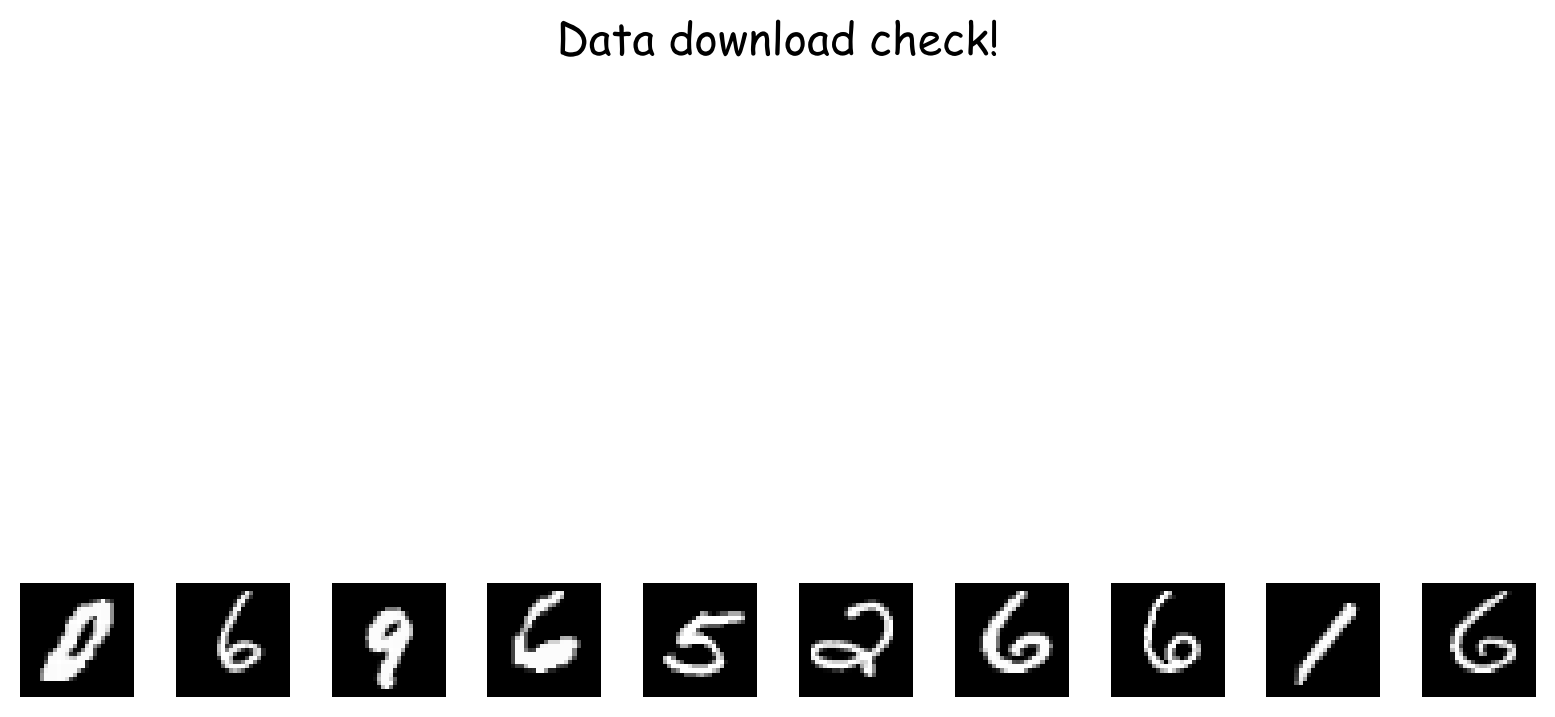

In [51]:
# @title Data retrieval

import contextlib
import io
import pandas as pd
import requests
import os
import hashlib

def download_file(fname, url, expected_md5):
    """
    Downloads a file from the given URL and saves it locally.
    """
    if not os.path.isfile(fname):
        try:
            r = requests.get(url)
        except requests.ConnectionError:
            print("!!! Failed to download data !!!")
            return
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
            return
        if hashlib.md5(r.content).hexdigest() != expected_md5:
            print("!!! Data download appears corrupted !!!")
            return
        with open(fname, "wb") as fid:
            fid.write(r.content)

data_files = [
    {
        "fname": "accuracy.csv",
        "url": "https://osf.io/aqhd3/download",
        "expected_md5": "bfcad2350de4c4a6eeeb1f3342371390"
    },
    {
        "fname": "cosine_similarity.csv",
        "url": "https://osf.io/w4pv7/download",
        "expected_md5": "97ac863216a44909bb930715855a1d9e"
    },
    {
        "fname": "losses.csv",
        "url": "https://osf.io/drfg6/download",
        "expected_md5": "e6a50509c676b6a934d653afae3a60c6"
    },
    {
        "fname": "snr.csv",
        "url": "https://osf.io/z5mjy/download",
        "expected_md5": "13b4f0e43cc8dce12a4d191ae2d31c0e"
    }
]

for data_file in data_files:
    download_file(data_file["fname"], data_file["url"], data_file["expected_md5"])

accuracy_data = pd.read_csv("accuracy.csv")
cosine_similarity_data = pd.read_csv("cosine_similarity.csv")
losses_data = pd.read_csv("losses.csv")
snr_data = pd.read_csv("snr.csv")

with contextlib.redirect_stdout(io.StringIO()):
    # Load the MNIST dataset, 50K training images, 10K validation, 10K testing
    train_set = datasets.MNIST('./', transform=transforms.ToTensor(), train=True, download=True)
    test_set = datasets.MNIST('./', transform=transforms.ToTensor(), train=False, download=True)

    rng_data = np.random.default_rng(seed=42)
    train_num = 50000
    shuffled_train_idx = rng_data.permutation(train_num)

    full_train_images = train_set.data.numpy().astype(float) / 255
    train_images = full_train_images[shuffled_train_idx[:train_num]].reshape((-1, 784)).T.copy()
    valid_images = full_train_images[shuffled_train_idx[train_num:]].reshape((-1, 784)).T.copy()
    test_images = (test_set.data.numpy().astype(float) / 255).reshape((-1, 784)).T

    full_train_labels = torch.nn.functional.one_hot(train_set.targets, num_classes=10).numpy()
    train_labels = full_train_labels[shuffled_train_idx[:train_num]].T.copy()
    valid_labels = full_train_labels[shuffled_train_idx[train_num:]].T.copy()
    test_labels = torch.nn.functional.one_hot(test_set.targets, num_classes=10).numpy().T

    full_train_images = None
    full_train_labels = None
    train_set = None
    test_set = None

#Plot some example images to make sure everything is loaded in properly
with plt.xkcd():
    fig, axs = plt.subplots(1,10)
    for c in range(10):
        axs[c].imshow(train_images[:,c].reshape((28,28)), cmap='gray')
        axs[c].axis("off")
    fig.suptitle("Data download check!", fontsize=16)
    plt.show()

---
# Section 1: Weight Perturbation

In this section, we will start exploring the learning algorithms which exhibit increased variance.

In [ ]:
# @title Video 1: Weight Perturbation

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'WOSTwEQXdlc'), ('Bilibili', 'BV1Gz42187Dr')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_video_1")


$
\newcommand{\stim}{\mathbf{x}}
\newcommand{\noisew}{\boldsymbol \Psi}
\newcommand{\noiser}{\boldsymbol \xi}
\newcommand{\target}{y}
\newcommand{\targetdim}{\mathbf{y}}
\newcommand{\identity}{\mathbf{I}}
\newcommand{\blackbox}{f}
\newcommand{\weight}{\mathbf{W}}
\newcommand{\loss}{\mathcal{L}}
\newcommand{\derivative}[2]{\frac{d#1}{d#2}}
\newcommand{\pderivative}[2]{\frac{\partial#1}{\partial#2}}
\newcommand{\rate}{\mathbf{r}}
\newcommand{\T}{^{\top}}
\newcommand{\RR}{\mathbb{R}}
\newcommand{\EE}{\mathbb{E}\,}
\newcommand{\brackets}[1]{\left(#1\right)}
\newcommand{\sqbrackets}[1]{\left[#1\right]}
\newcommand{\var}[1]{\mathbb{V}\mathrm{ar}\brackets{#1}}$

In this first section, we will be deriving and implementing the __Weight Perturbation__ algorithm. In the next section, we will be deriving and implementing the __Node Perturbation__ algorithm. Both of these methods of gradient estimation are very closely related to *finite differences* derivative approximation.

 Suppose that we have some loss function, $\loss(\Delta \weight)$, which we would like to minimize by making some change in our synaptic weights, $\Delta \weight$. The most natural way to decrease the loss would be to perform gradient descent; however, it is not reasonable to assume that a synapse in the brain could perform analytic gradient calculations for general loss functions $\loss(\Delta \weight)$, which may depend on the activity of many downstream neurons and the external environment. Biological systems could solve this problem by *approximating* the gradient of the loss, which could be accomplished in many ways. 
 
 To start, we will provide the __weight perturbation__ update, and will subsequently demonstrate why it provides an estimate of the gradient. We will first add noise to our weights, using $\weight' = \weight + \noisew$, where $\noisew \sim \mathcal N(0, \sigma^2)$. We take as our update:

\begin{equation}
    \Delta \weight =  - \eta \mathbb{E}_{\noisew} \left [\left (\loss(\noisew) - \loss(0)\right ) \frac{(\weight' - \weight)}{\sigma^2} \right ].
\end{equation}
First, we will clarify why this parameter update is interesting from a neuroscientific perspective. If we look at the parameter update for a *single synapse*, $\weight_{ij}$, we have:
\begin{align}
    \Delta \weight_{ij} &=  - \eta \mathbb{E}_{\noisew} \left [\left (\loss(\noisew) - \loss(0)\right ) \frac{(\weight'_{ij} - \weight_{ij})}{\sigma^2} \right ] \\
    & \approx  - \eta \frac{1}{K}\sum_{k = 0}^K\left [\left (\loss(\noisew^{(k)}) - \loss(0)\right ) \frac{(\weight'^{(k)}_{ij} - \weight_{ij})}{\sigma^2} \right ],
\end{align}

where for the last approximate equality we are substituting an expectation over $\noisew$ for an empirical approximation over $K$ samples of $\noisew$. This update only requires information about the global loss, $\loss(\noisew^{(k)})$ and the local parameter values, $\weight'^{(k)}_{ij}$: using this update, a synapse in a neural network can adapt its strength with *very little* information about what is going on in the rest of the neural circuit.

Lastly, we will show why this update is an approximation of the loss gradient: this section is only to satisfy your curiosity, and is not necessary for completing the coding exercises. We first notice that by first-order Taylor expansion $\loss(\noisew) \approx \loss(0) + \derivative{\loss}{\weight}\T \noisew$. Plugging this approximation into our update equation, we get:
\begin{align}
    \Delta \weight_{ij} &=  - \eta \mathbb{E}_{\noisew} \left [\left (\derivative{\loss}{\weight}\T \noisew\right ) \frac{\noisew_{ij}}{\sigma^2} \right ] \\
    &=  - \eta \derivative{\loss}{\weight_{ij}},
\end{align}
where this last equality follows from the fact that $\mathbb{E}_{\noisew} \left[\noisew_{ij} \noisew_{kl} \right] = \sigma^2$ if and only if $i = k$ and $j = l$, and is 0 otherwise. Therefore, in expectation over many noise samples $\noisew$, our parameter update based purely on measuring how perturbations of the weights $\weight'$ correlate with changes in the loss function $\loss(\noisew)$, ends up being an unbiased approximation of gradient descent.


In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_weight_perturbation")

## Exercise 1: Perturb the weights

In this section, fill out the function 'perturb' for the WeightPerturbMLP class. This function is used to update the parameters of our MLP network using the weight perturbation algorithm, using the parameter update equations from the preceding section.

In [ ]:
class WeightPerturbMLP(MLP):
    """
    A multilayer perceptron that is capable of learning through weight perturbation
    """

    def perturb(self, rng, inputs, targets, noise=1.0):
        """
        Calculates the weight updates for perturbation learning, using noise with SD as given
        """
        ###################################################################
        ## Fill out the following then remove
        raise NotImplementedError("Student exercise: determine the sign of the updates")
        ###################################################################

        # get the random perturbations
        delta_W_h = rng.normal(scale=noise, size=self.W_h.shape)
        delta_W_y = rng.normal(scale=noise, size=self.W_y.shape)

        # calculate the loss with and without the perturbations
        loss_now = self.mse_loss(rng, inputs, targets)
        loss_per = self.mse_loss(rng, inputs, targets, self.W_h + delta_W_h, self.W_y + delta_W_y)

        # updates
        delta_loss = ...
        W_h_update = delta_loss * delta_W_h / noise ** 2
        W_y_update = delta_loss * delta_W_y / noise ** 2
        return W_h_update, W_y_update

In [5]:
# to_remove solution

class WeightPerturbMLP(MLP):
    """
    A multilayer perceptron that is capable of learning through weight perturbation
    """

    def perturb(self, rng, inputs, targets, noise=1.0):
        """
        Calculates the weight updates for perturbation learning, using noise with SD as given
        """

        # get the random perturbations
        delta_W_h = rng.normal(scale=noise, size=self.W_h.shape)
        delta_W_y = rng.normal(scale=noise, size=self.W_y.shape)

        # calculate the loss with and without the perturbations
        loss_now = self.mse_loss(rng, inputs, targets)
        loss_per = self.mse_loss(rng, inputs, targets, self.W_h + delta_W_h, self.W_y + delta_W_y)

        # updates
        delta_loss = loss_now - loss_per
        W_h_update = delta_loss * delta_W_h / noise ** 2
        W_y_update = delta_loss * delta_W_y / noise ** 2
        return W_h_update, W_y_update

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_perturb_the_weights")

## Training an MLP on MNIST with weight perturbation

Having implemented the appropriate update function, we will now verify that it works by training a network. We will train a simple MLP on the MNIST dataset, using the weight perturbation algorithm to estimate the gradient. This MLP consists of:

* An input layer with 784 units
* A hidden layer with 500 units
* An output layer with 10 units, one for each of the digits 0-9

We will use the **mean-squared error loss** on the one-hot encoded labels–this is just to make later calculations more tractable, but typically one would use the cross-entropy loss. We'll train the network for 3 epochs. All in all, the weight perturbation update acts as a drop-in replacement for conventional gradient descent.

In [6]:
# @title Hyperparameters definition

numhidden = 500
batchsize = 200
initweight = 0.1
learnrate = 0.001
noise = 0.1
numepochs = 3
numrepeats = 1
numbatches = int(train_images.shape[1] / batchsize)
numupdates = numepochs * numbatches
activation = 'sigmoid'
report = True
rep_rate = 1
seed = 12345

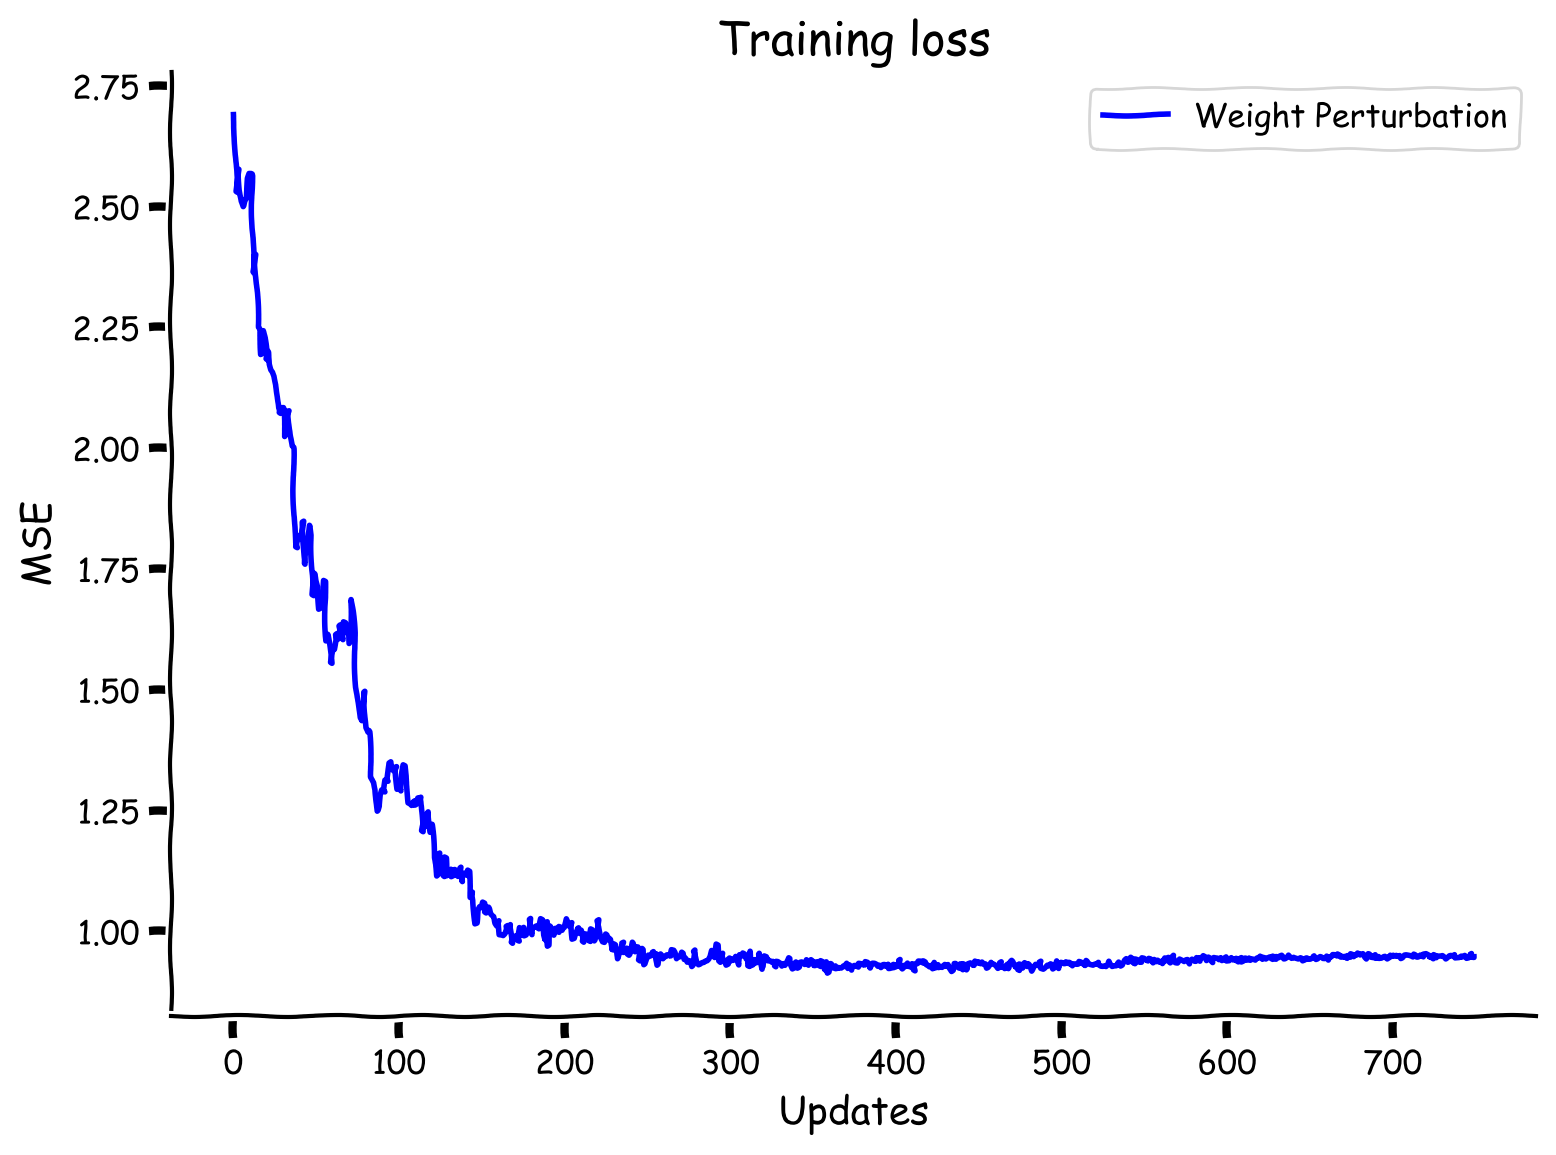

In [39]:
# @title Train and observe the performance of WeightPerturbMLP

rng_wp = np.random.default_rng(seed=seed)
losses_perturb = np.zeros((numupdates,))
accuracy_perturb = np.zeros((numepochs,))

# select 1000 random images to test the accuracy on
indices = rng_wp.choice(range(test_images.shape[1]), size=(1000,), replace=False)

# create a network and train it using weight perturbation
netperturb = WeightPerturbMLP(rng_wp, numhidden, sigma=initweight, activation=activation)
(losses_perturb[:], accuracy_perturb[:], _, snr_perturb) = \
    netperturb.train(rng_wp, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                     learning_rate=learnrate, batch_size=batchsize, algorithm='perturb', noise=noise, \
                     report=report, report_rate=rep_rate)

# plot performance over time
with plt.xkcd():
    plt.plot(losses_data['weight_perturbation'], label="Weight Perturbation", color='b') #pre-saved history of loss
    plt.xlabel("Updates")
    plt.ylabel("MSE")
    plt.legend()
    plt.title("Training loss")
    plt.show()

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_training_with_weight_perturbation")

---
# Section 2: Node Perturbation

Estimated timing to here from start of tutorial: 30 minutes

While we can get an unbiased derivative approximation based solely on perturbations of the weights, we will show later on that this is actually a very inefficient method, because it requires averaging out $MN$ noise sources, where $M$ is the dimension of the input $\stim$ and $N$ is the dimension of the hidden activity $\rate$. 

![Network.](https://github.com/neuromatch/NeuroAI_Course/blob/main/tutorials/W2D3_Microlearning/static/network.png?raw=true)

For simplicity, consider what happens in a network with a linear hidden layer. If we add noise at the level of the hidden units $\rate = \weight \stim$, we will only have to average over $N$ noise sources. To do this, we can use the following update, taking $\rate' = \rate + \noiser$, where $\noiser \sim \mathcal{N}(0,\sigma^2)$:

\begin{equation}
    \Delta \weight =  - \eta \mathbb{E}_{\noiser} \left [\left(\loss(\noiser) - \loss(0) \right ) \frac{(\rate' - \rate)}{\sigma^2} \stim\T \right ].
\end{equation}
We will now show why this update is interesting from a neuroscience perspective (for much the same reason as for weight perturbation). For a single synapse, the approximate update using samples of $\noiser$ is given by:
\begin{equation}
    \Delta \weight_{ij} \approx - \eta \frac{1}{K} \sum_{k=0}^{K} \left [\left(\loss(\noiser^{(k)}) - \loss(0) \right ) \frac{(\rate'^{(k)}_i - \rate_i)}{\sigma^2} \stim_j \right ].
\end{equation}
Once again this update requires very little knowledge about the rest of the neural circuit in order for a synapse to compute it. It requires knowledge of the global loss, $\loss(\noiser^{(k)})$, postsynaptic activity $\rate^{(k)}_i$, and presynaptic activity $\stim_j$. This form of parameter update is often called a Reward (loss)-modulated Hebbian plasticity rule, or a 3-factor plasticity rule.

Lastly, we will show why this update is an unbiased gradient estimate: again, this section is only to satisfy your curiosity, and is not needed for the coding exercises. We again employ a first-order Taylor expansion: $\loss(\noiser) \approx \loss(0) + \derivative{\loss}{\rate}\T\noiser$, to get:
\begin{align}
    \Delta \weight_{ij} &=  - \eta \mathbb{E}_{\noiser} \left [\left(\derivative{\loss}{\rate}\T\noiser \right ) \frac{\noiser_i}{\sigma^2} \stim_j \right ] \\
    &=  - \eta \pderivative{\loss}{\rate_i} \stim_j \\
    &=  - \eta \pderivative{\loss}{\rate_i} \pderivative{\rate_i}{\weight_{ij}}\\
    &=  - \eta \pderivative{\loss}{\weight_{ij}},
\end{align}
Where the second equality follows from the fact that $\mathbb{E}_{\noiser} \left [ \noiser_i \noiser_k \right ] = \sigma^2$ if and only if $i = k$, and is 0 otherwise. This analysis shows that we can estimate derivatives by correlating fluctuations in either $\weight$ *or* $\rate$ with fluctuations in the loss function. Neither strategy requires evaluating derivatives of $\blackbox(\cdot)$, they only require some extrinsic measure of performance, given by $\mathcal{L}$ and how performance varies in response to perturbations in either weights or nodes, respectively. In subsequent sections, we will investigate how these different methods compare in terms of their ability to estimate gradients in systems with large numbers of neurons. We will show that there is no free lunch--though these methods require less information, they are less *efficient* than analytic gradient calculations.

Below, we provide an implementation of the node perturbation algorithm, so that you will be able to compare it to the weight perturbation algorithm in subsequent sections. Running this code will take around 9 minutes--you can move on to subsequent sections while you wait!

One important detail: there are two different notions of efficiency we could consider here: 1) sample efficiency and 2) runtime efficiency. Node perturbation is more sample efficient: in general it brings the loss lower with fewer samples than weight perturbation. However, our particular implementation of node perturbation runs a little slower than weight perturbation, so you could argue that it has worse runtime efficiency. This is just due to the fact that these algorithms were implemented by different people, and the author for node perturbation exploited python parallel computation a little less effectively.

In [8]:
class NodePerturbMLP(MLP):
    """
    A multilayer perceptron that is capable of learning through node perturbation
    """

    def node_perturb(self, rng, inputs, targets, noise=1.0):
        """
        Calculates the weight updates for node perturbation learning, using noise with SD as given
        """

        # get the random perturbations
        hidden, output = self.inference(rng, inputs)
        hidden_p, output_p = self.inference(rng, inputs, noise=noise)

        loss_now = self.mse_loss_batch(rng, inputs, targets, output=output)
        loss_per = self.mse_loss_batch(rng, inputs, targets, output=output_p)
        delta_loss = loss_now - loss_per

        hidden_update = np.mean(
            delta_loss * (((hidden_p - hidden) / noise ** 2)[:, None, :] * add_bias(inputs)[None, :, :]), axis=2)
        output_update = np.mean(
            delta_loss * (((output_p - output) / noise ** 2)[:, None, :] * add_bias(hidden_p)[None, :, :]), axis=2)

        return (hidden_update, output_update)

In [41]:
# @title Train and observe the performance of NodePerturbMLP

losses_node_perturb = np.zeros((numupdates,))
accuracy_node_perturb = np.zeros((numepochs,))

# set the random seed
rng_np = np.random.default_rng(seed=seed)

# select 1000 random images to test the accuracy on
indices = rng_np.choice(range(test_images.shape[1]), size=(1000,), replace=False)

# create a network and train it using weight perturbation
with contextlib.redirect_stdout(io.StringIO()):
    netnodeperturb = NodePerturbMLP(rng_np, numhidden, sigma=initweight, activation=activation)
    (losses_node_perturb[:], accuracy_node_perturb[:], _, snr_node_perturb) = \
        netnodeperturb.train(rng_np, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                             learning_rate=learnrate, batch_size=batchsize, algorithm='node_perturb', noise=noise, \
                             report=report, report_rate=rep_rate)

# plot performance over time
with plt.xkcd():
    plt.plot(losses_data['node_perturbation'], label="Node Perturbation", color='c') #pre-saved history of loss
    plt.plot(losses_data['weight_perturbation'], label="Weight Perturbation", color='b') #pre-saved history of loss
    plt.xlabel("Updates")
    plt.ylabel("MSE")
    plt.legend()
    plt.title("Training loss")
    plt.show()

KeyboardInterrupt: 

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_node_perturbation")

---
# Section 3: Assessing the variance of learning algorithms

Estimated timing to here from start of tutorial: 45 minutes

In this section, we will evaluate the robustness of the introduced learning algorithms by assessing their variance.

In [ ]:
# @title Video 2: Assessing Variance

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'C8L2n8VBQlc'), ('Bilibili', 'BV14y41187Tn')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_video_2")

$\newcommand{\stim}{\mathbf{x}}$
$\newcommand{\noisew}{\boldsymbol \Psi}$
$\newcommand{\noiser}{\boldsymbol \xi}$
$\newcommand{\target}{y}$
$\newcommand{\targetdim}{\mathbf{y}}$
$\newcommand{\identity}{\mathbf{I}}$
$\newcommand{\blackbox}{f}$
$\newcommand{\weight}{\mathbf{W}}$
$\newcommand{\loss}{\mathcal{L}}$
$\newcommand{\derivative}[2]{\frac{d#1}{d#2}}$
$\newcommand{\rate}{\mathbf{r}}$
$\newcommand{\T}{^{\top}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}\,}$
$\newcommand{\brackets}[1]{\left(#1\right)}$
$\newcommand{\sqbrackets}[1]{\left[#1\right]}$
$\newcommand{\var}[1]{\mathbb{V}\mathrm{ar}\brackets{#1}}$

The main issue of perturbation methods is noise, meaning that across many samples of input stimuli and network perturbations, the gradient estimates will be much more variable than would be the case for backpropagation. This means that many, many more perturbations/training samples will be required to obtain an accurate gradient estimate: the consequence will be either very slow or much less effective learning. 

Here, we will demonstrate the noisiness of these learning algorithms analytically for a simplified loss and network. This derivation is principally to satisfy your curiosity: no subsequent exercises will depend on your understanding of the mathematics here, and we will subsequently provide empirical evidence based on network simulations as well. First, we will work with a linear network so $\widehat\targetdim =\weight\stim$, where $\widehat\targetdim\in\RR^M$, $\weight\in\RR^{M\times N}$ and $\stim\in\RR^N$. Second, we will assume that the target output is zero $\targetdim=0$, so the loss  becomes $\loss(\weight)=\frac{1}{2}\|\weight\stim\|^2_2$. (This is equivalent to saying that $\targetdim=\weight^*\stim$ and then shifting the actual weights to be $\weight - \weight^*$; notice that here we treat the loss as a function of $\weight$, rather than $\Delta \weight$.)


With these changes, we will compute the variance of weight updates for a given input $\stim$, i.e.
\begin{equation*}
    \var{\Delta \weight}=\EE\brackets{\Delta \weight - \EE\Delta\weight}^2 = \EE\brackets{\Delta \weight}^2 - \brackets{\EE\Delta\weight}^2\,.
\end{equation*}
We already know that the $\EE\Delta\weight$ is the gradient update, so
\begin{equation}
   \brackets{\EE\Delta\weight_{ij}}^2 =  \eta^2  \brackets{\derivative{\loss}{\weight}}_{ij}^2.
\end{equation}

Therefore we only need to compute $\EE(\Delta\weight)^2$ for both algorithms.

**Weight perturbation** For a single weight $\weight_{ij}$, we can use the approximate weight change:
\begin{align}
    \Delta \weight_{ij} \,&=  - \eta \sum_{kl} \brackets{\brackets{\derivative{\loss}{\weight}}_{kl} \noisew_{kl}} \frac{\noisew_{ij}}{\sigma^2}\,,\\
    \brackets{\Delta \weight_{ij}}^2 \,&=  \frac{\eta^2}{\sigma^4} \brackets{\sum_{kl}\brackets{\derivative{\loss}{\weight}}_{kl} \noisew_{kl}}^2 \noisew_{ij}^2\\
    &=\frac{\eta^2}{\sigma^4} \brackets{\sum_{kldn}\brackets{\derivative{\loss}{\weight}}_{kl}\brackets{\derivative{\loss}{\weight}}_{dn} \noisew_{kl}\noisew_{dn}} \noisew_{ij}^2\,.
\end{align}

Now we can take the expectation of the last line w.r.t. the noise $\noisew$. Since all entries of the noise matrix are independent and zero-mean Gaussian, we will have non-zero terms in two case: $kl=dn\neq ij$ and $kl=dn=ij$:
\begin{align}
    \EE\noisew_{kl}\noisew_{dn}\noisew_{ij}^2 = \begin{cases}
        0 & k \neq d\ \mathrm{or}\ l\neq n\\
        \sigma^4 & k=d, l=n, (k\neq i\ \mathrm{or}\ l\neq j)\\
        3\,\sigma^4 & k=d=i,l=n=j
    \end{cases}
\end{align}

Therefore,
\begin{align}
    \EE_{\noisew}\brackets{\brackets{\Delta \weight_{ij}}^2} \,& = \frac{\eta^2}{\sigma^4}  \brackets{\derivative{\loss}{\weight}}_{ij}^2 \EE \noisew_{ij}^4 + \frac{\eta^2}{\sigma^4} \sum_{kl\neq ij} \brackets{\derivative{\loss}{\weight}}_{kl}^2 \EE\brackets{\noisew_{kl}^2 \noisew_{ij}^2}\\
    &=3\eta^2  \brackets{\derivative{\loss}{\weight}}_{ij}^2 + \eta^2\sum_{kl\neq ij} \brackets{\derivative{\loss}{\weight}}_{kl}^2\,,
\end{align}

where we used that the 4th central of the Gaussian $\EE \noisew_{ij}^4=3\sigma^4$.

Using the above result, we arrive at
\begin{align}
    \var{\Delta \weight_{ij}} = \eta^2  \brackets{\derivative{\loss}{\weight}}_{ij}^2 + \eta^2\sum_{kl} \brackets{\derivative{\loss}{\weight}}_{kl}^2 = O(MN)\,,
\end{align}
where the scaling comes from having $MN$ terms in the sum.

**Node perturbation** Again, for a single weight $\weight_{ij}$, we can use the approximate weight change:
\begin{align}
    \Delta \weight_{ij} \,&= -\frac{\eta}{\sigma^2}\brackets{\sum_{k}\brackets{\derivative{\loss}{\rate}}_k\noiser_k} \noiser_i\stim_j\,,\\
    \brackets{\Delta \weight_{ij}}^2 \,&= \frac{\eta^2}{\sigma^4}\brackets{\sum_{k}\brackets{\derivative{\loss}{\rate}}_k\noiser_k}^2 \noiser_i^2\stim_j^2\\
    &=\frac{\eta^2}{\sigma^4}\brackets{\sum_{k,d}\brackets{\derivative{\loss}{\rate}}_k\brackets{\derivative{\loss}{\rate}}_d\noiser_k\noiser_d} \noiser_i^2\stim_j^2\,.
\end{align}

Again, computing the expectation over the last line will make use of the independent zero-mean Gaussian noise:
\begin{align}
    \EE\noiser_k\noiser_d\noiser_i^2 = \begin{cases}
        0 & k \neq d\\
        \sigma^4 & k=d\neq i\\
        3\,\sigma^4 & k=d=i
    \end{cases}
\end{align}

Since only $k=d\neq i$ and $k=d=i$ terms will remain non-zero, we obtain
\begin{align}
    \EE_{\noiser}\brackets{\brackets{\Delta \weight_{ij}}^2} \,&= \frac{\eta^2}{\sigma^4}\brackets{\derivative{\loss}{\rate}}_i^2 \EE\brackets{\noiser_i^4}\stim_j^2 + \frac{\eta^2}{\sigma^4}\brackets{\sum_{k\neq i}\brackets{\derivative{\loss}{\rate}}_k^2\EE\brackets{\noiser_k^2 \noiser_i^2}\stim_j^2}\\
    &=3 \eta^2\brackets{\derivative{\loss}{\rate}}_i^2 \stim_j^2 + \eta^2\sum_{k\neq i}\brackets{\derivative{\loss}{\rate}}_k^2\stim_j^2\,.
\end{align}

Now since $\brackets{\EE_{\noiser}\Delta \weight_{ij}}^2=\eta^2\brackets{\derivative{\loss}{\rate}}_i^2 \stim_j^2$, we have
\begin{equation}
    \var{\Delta \weight_{ij}} = \eta^2\brackets{\derivative{\loss}{\rate}}_i^2 \stim_j^2 + \eta^2\sum_{k}\brackets{\derivative{\loss}{\rate}}_k^2\stim_j^2 = O(M)\,,
\end{equation}
where the scaling comes from the sum over $M$ outputs. 

To conclude, we found that the variance of the __weight perturbation__ method scales as $O(MN)$ (variance increases if there are more inputs and/or more outputs), while the __node perturbation__ variance scales as $O(M)$ (variance increases only if there are more outputs). As such, node perturbation will scale better as the number of inputs or the number of neurons in the network increases, while weight perturbation will do worse. As we will see below, neither of these methods will scale as well as backpropagation. Becoming less effective at scale is a major problem for a learning algorithm operating in the brain, where synaptic modifications may occur in billions of neurons, and potentially trillions of synapses.

### Empirical demonstration

Below, we provide an empirical comparison between the gradient estimates provided by three algorithms: __Weight Perturbation__, __Node Perturbation__, and __Backpropagation__.

To compare the variances of these different algorithms, we will use the __Signal-to-Noise Ratio (SNR)__, averaged across network parameters. For a random variable $X$, the SNR is defined as:

\begin{equation}
\text{SNR}(X) = \frac{|\text{Mean}(X)|}{\text{Std}(X)}.
\end{equation}

Here the mean and standard deviation are taken over the test samples (across the batch dimension). The SNR is smaller when X is noisier. For the purposes of comparing gradient estimates, the SNR is a superior measure compared to the variance, because it is *scale invariant*: while the variance scales quadratically if the gradient estimate is multiplied by a scalar $\eta$ (for instance a learning rate), the SNR remains unchanged! This means that we will be able to meaningfully compare gradient updates that are of different sizes, and will prevent algorithms with smaller gradient updates from appearing spuriously low-noise.

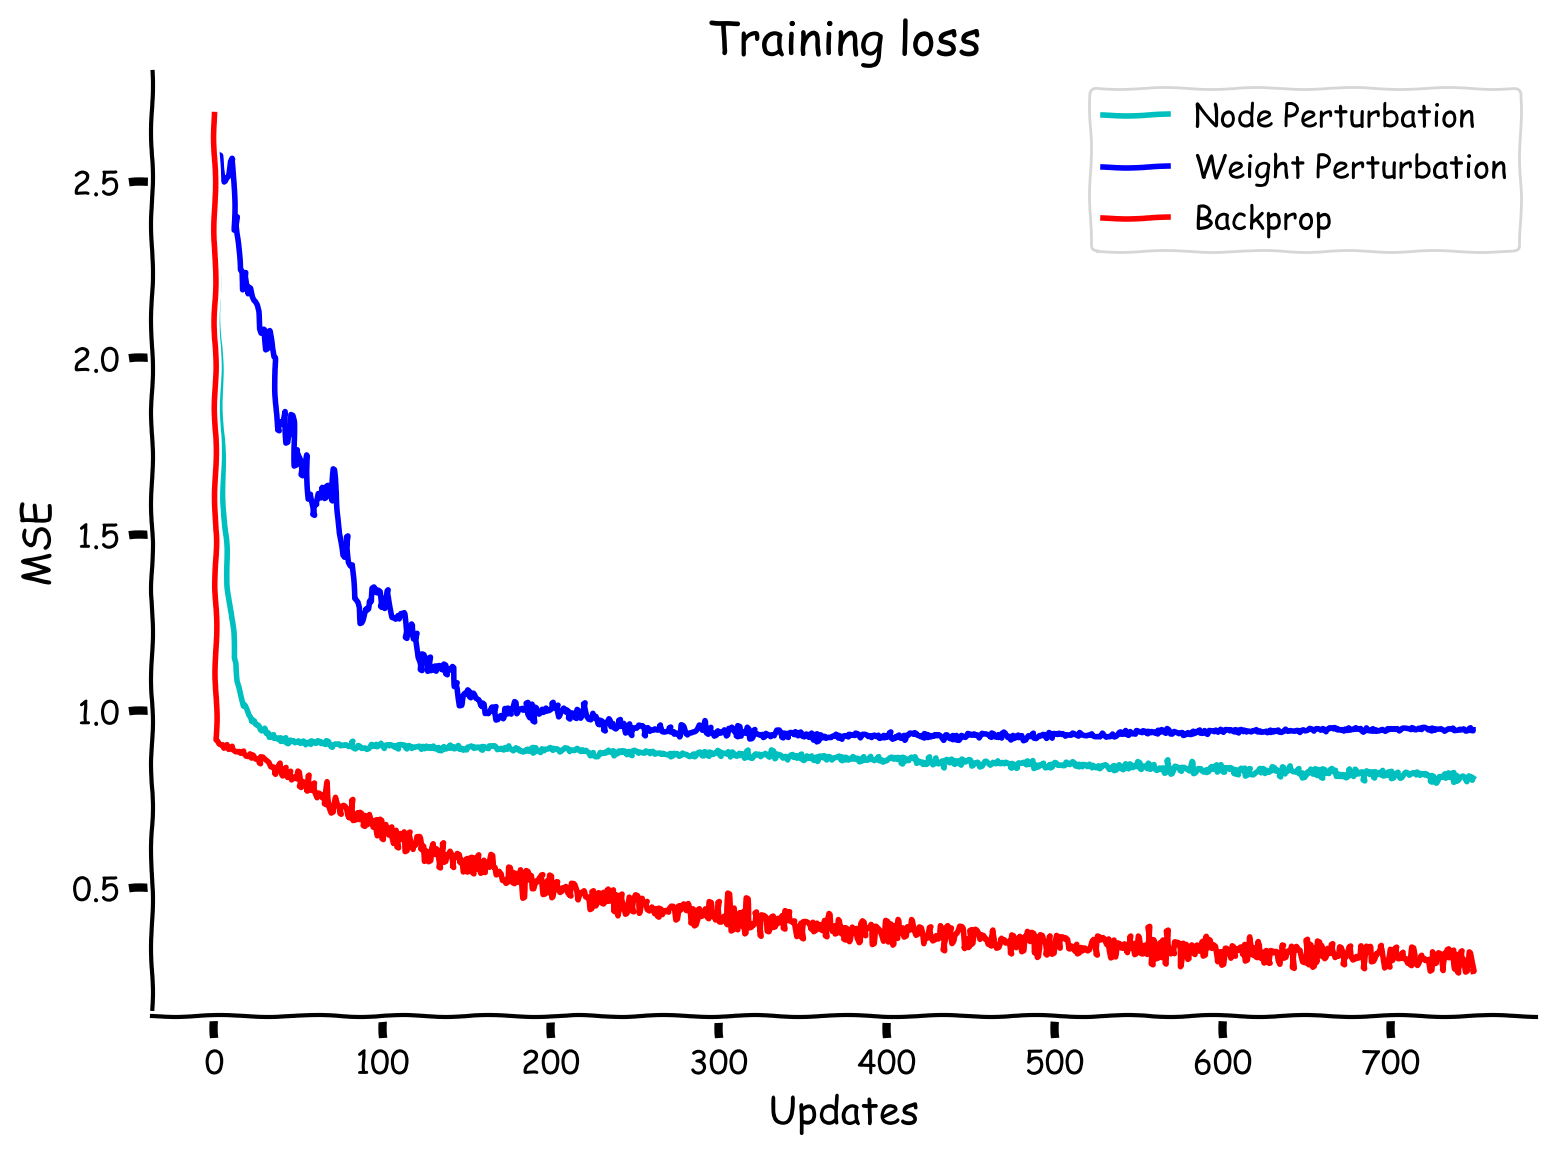

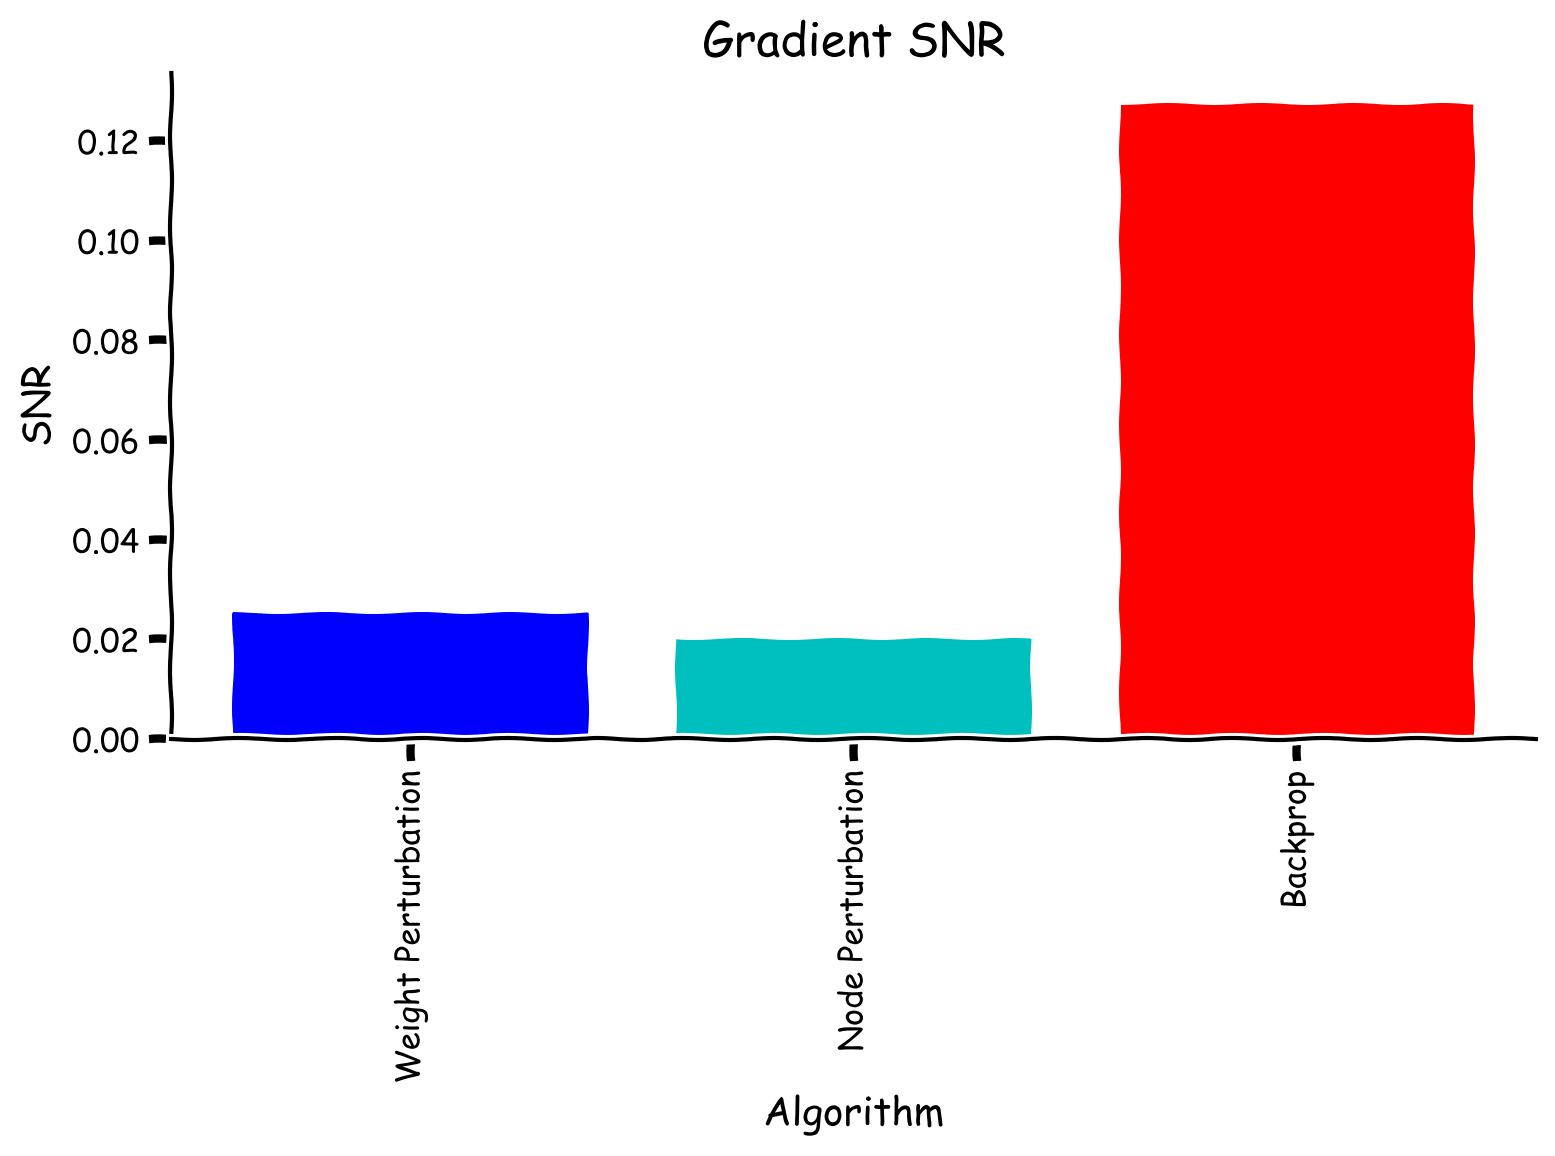

In [56]:
# @title Compare the SNRs for Weight Perturbation, Node Perturbation, and Backpropagation

# initialize the loss and accuracy holders
# losses_backprop = np.zeros((numupdates,))
# accuracy_backprop = np.zeros((numepochs,))

# # First, we have to train a network with Backpropagation for comparison

# # set the random seed to the current time
# rng_bp = np.random.default_rng(seed=seed)

# # select 1000 random images to test the accuracy on
# indices = rng_bp.choice(range(test_images.shape[1]), size=(1000,), replace=False)

# # create a network and train it using backprop
# netbackprop = MLP(rng_np, numhidden, sigma=initweight, activation=activation)
# (losses_backprop[:], accuracy_backprop[:], _, snr_backprop) = \
#     netbackprop.train(rng_bp, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
#                       learning_rate=learnrate, batch_size=batchsize, algorithm='backprop', noise=noise, \
#                       report=report, report_rate=rep_rate)

# plot performance over time
with plt.xkcd():
    plt.plot(losses_data['node_perturbation'], label="Node Perturbation", color='c') #pre-saved history of loss
    plt.plot(losses_data['weight_perturbation'], label="Weight Perturbation", color='b') #pre-saved history of loss
    plt.plot(losses_data['backpropagation'], label="Backprop", color='r') #pre-saved history of loss
    plt.xlabel("Updates")
    plt.ylabel("MSE")
    plt.legend()
    plt.title("Training loss")
    plt.show()

# plot the SNR at initialization for the three learning algorithms
with plt.xkcd():
    plt.figure()
    x = [0, 1, 2]
    snr_vals = [snr_data['weight_perturbation'][0], snr_data['node_perturbation'][0], snr_data['backpropagation'][0]] #pre-saved snrs
    colors = ['b', 'c', 'r']
    labels = ['Weight Perturbation', 'Node Perturbation', 'Backprop']
    plt.bar(x, snr_vals, color=colors, tick_label=labels)
    plt.xticks(rotation=90)
    plt.ylabel('SNR')
    plt.xlabel('Algorithm')
    plt.title('Gradient SNR')
    plt.show()

As should be evident, the signal-to-noise ratio for both weight and node perturbation are much worse than for backpropagation. This is also reflected in the poor performance of both algorithms relative to backpropagation. This shows that locality of parameter updates often comes at the price of poor performance.

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_assessing_variance")

---
# Section 4: Feedback Alignment 

Estimated timing to here from start of tutorial: 1 hour

This section will introduce another family of learning algorithms that exhibit no variance but become biased.

In [ ]:
# @title Video 3: Feedback Alignment

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'aTsuAveKf90'), ('Bilibili', 'BV1jD421u75F')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_video_3")


$\newcommand{\stim}{\mathbf{x}}$
$\newcommand{\h}{\mathbf{h}}$
$\newcommand{\noisew}{\boldsymbol \Psi}$
$\newcommand{\noiser}{\boldsymbol \xi}$
$\newcommand{\target}{y}$
$\newcommand{\pred}{\mathbf{\hat{y}}}$
$\newcommand{\identity}{\mathbf{I}}$
$\newcommand{\blackbox}{f}$
$\newcommand{\weight}{\mathbf{W}}$
$\newcommand{\weightout}{\mathbf{W}^{\textrm{out}}}$
$\newcommand{\loss}{\mathcal{L}}$
$\newcommand{\derivative}[2]{\frac{\partial#1}{\partial#2}}$
$\newcommand{\rate}{\mathbf{r}}$
$\newcommand{\error}{\boldsymbol \delta}$
$\newcommand{\losserror}{\mathbf{e}}$
$\newcommand{\backweight}{\mathbf{B}}$

In this section, we describe the __Feedback Alignment__ algorithm. Unlike weight and node perturbation, feedback alignment provides a mechanism whereby individual neurons can receive *targeted* error signals. To start, we assume the following network setup:

\begin{align}
    \pred = \blackbox(\weight \stim) = \weightout\sigma(\weight\stim) =\weightout \h
\end{align}

With a mean squared error loss over all of the output neurons.
\begin{equation}
    \loss = \frac{1}{2n} \sum_{k=1}^{n}\left (\target_k - \hat{y}_k \right )^2
\end{equation}

Note here we have suppressed the batch index notation, and will calculate the following gradients as averages over batch elements.

Backpropagation updates parameters using the gradient of the loss scaled by the learning rate $\eta$.

\begin{align}
    \Delta \weight_{ji} &= - \eta \derivative{\loss}{\weight}_{ji} \\
    &= - \eta \underbrace{\derivative{\loss}{\pred}\derivative{\pred}{h_j}}_{\delta_j}\derivative{h_j}{\weight_{ji}}\\
    &= - \eta \delta_j \sigma^{\prime}(\weight\stim)_j\stim_i \\
    &= - \eta \delta_j h^{\prime}_j\stim_i
\end{align}

While $h^{\prime}_j$ and $\stim_i$ are available locally to the neuron, calculating $\delta_j$
involves non-local information, and is therefore biologically implausible.

\begin{align}
    \delta_j &= \derivative{\loss}{h_j} \\
    &= \sum_{k=1}^n \derivative{\loss}{\hat{y}_k}\derivative{\hat{y}_k}{h_j} \\
    &= \sum_{k=1}^n \overbrace{(y_k - \hat{y_k})}^{e_k} \weightout_{kj} \\
    &= e_1 {\color{red}\weightout_{1j}} + e_2 {\color{green}\weightout_{2j}} + e_3{\color{magenta}\weightout_{3j}}
\end{align}

In order to calculate $\delta_j$ we need to use all of of the outgoing weights from neuron $h_j$.

Writing $\error$ as a column vector (i.e. $\derivative{\loss}{\h}$ in  [denominator layout](https://en.wikipedia.org/wiki/Matrix_calculus#Layout_conventions)) we see that in order to calculate $\error$ we need the transpose of the forward weights.
\begin{align}
    \error &= \weight_{out}^T \losserror .
\end{align}

<img src="https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/tutorials/W2D3_Microlearning/static/feedback_alignment.png" width="400">

*From Lillicrap et al. (2016), CC-BY*

Feedback alignment replaces $\weight_{out}^T $ with a random matrix, $\backweight$. This resolves the 'weight transport' problem, because the feedback weights are no longer the same as the feedforward weights. However, by replacing $\weight_{out}^T$ with $\backweight$, we are no longer calculating an accurate gradient! Interestingly, we will see empirically in subsequent sections that this replacement still produces reasonably good gradient estimates, though it still introduces *bias*.

## Exercise 2: Feedback alignment algorithm

For this exercise, you are tasked with implementing the __Feedback Alignment__ algorithm in our MLP network. Fill in the proper gradient calculation steps below.

In [ ]:
class FeedbackAlignmentMLP(MLP):
    """
    A multilayer perceptron that is capable of learning through the Feedback Alignment algorithm
    """

    # function for calculating feedback alignment updates
    def feedback(self, rng, inputs, targets):
        """
        Calculates the weight updates for feedback alignment learning
        """
        ###################################################################
        ## Fill out the following then remove
        raise NotImplementedError("Student exercise: calculate the updates")
        ###################################################################

        # do a forward pass
        hidden, output = self.inference(rng, inputs)

        # calculate the updates
        error = ...
        delta_W_h = np.dot(np.dot(self.B, error * self.act_deriv(output)) * self.act_deriv(hidden),
                           add_bias(inputs).transpose())
        delta_W_y = ...

        return delta_W_h, delta_W_y

In [13]:
# to_remove solution

class FeedbackAlignmentMLP(MLP):
    """
    A multilayer perceptron that is capable of learning through the Feedback Alignment algorithm
    """

    # function for calculating feedback alignment updates
    def feedback(self, rng, inputs, targets):
        """
        Calculates the weight updates for feedback alignment learning
        """

        # do a forward pass
        hidden, output = self.inference(rng, inputs)

        # calculate the updates
        error = targets - output
        delta_W_h = np.dot(np.dot(self.B, error * self.act_deriv(output)) * self.act_deriv(hidden),
                           add_bias(inputs).transpose())
        delta_W_y = np.dot(error * self.act_deriv(output), add_bias(hidden).transpose())

        return delta_W_h, delta_W_y

Now that you have an implementation of Feedback Alignment, we can verify that it works properly by training a sample network.

In [14]:
# @title Define hyperparameters
numhidden  = 500
batchsize  = 200
initweight = 0.1
learnrate  = 0.001
noise      = 0.1
numepochs  = 3
numrepeats = 1
numbatches = int(train_images.shape[1] / batchsize)
numupdates = numepochs * numbatches
activation = 'sigmoid'
report     = True
rep_rate   = 1
seed = 12345

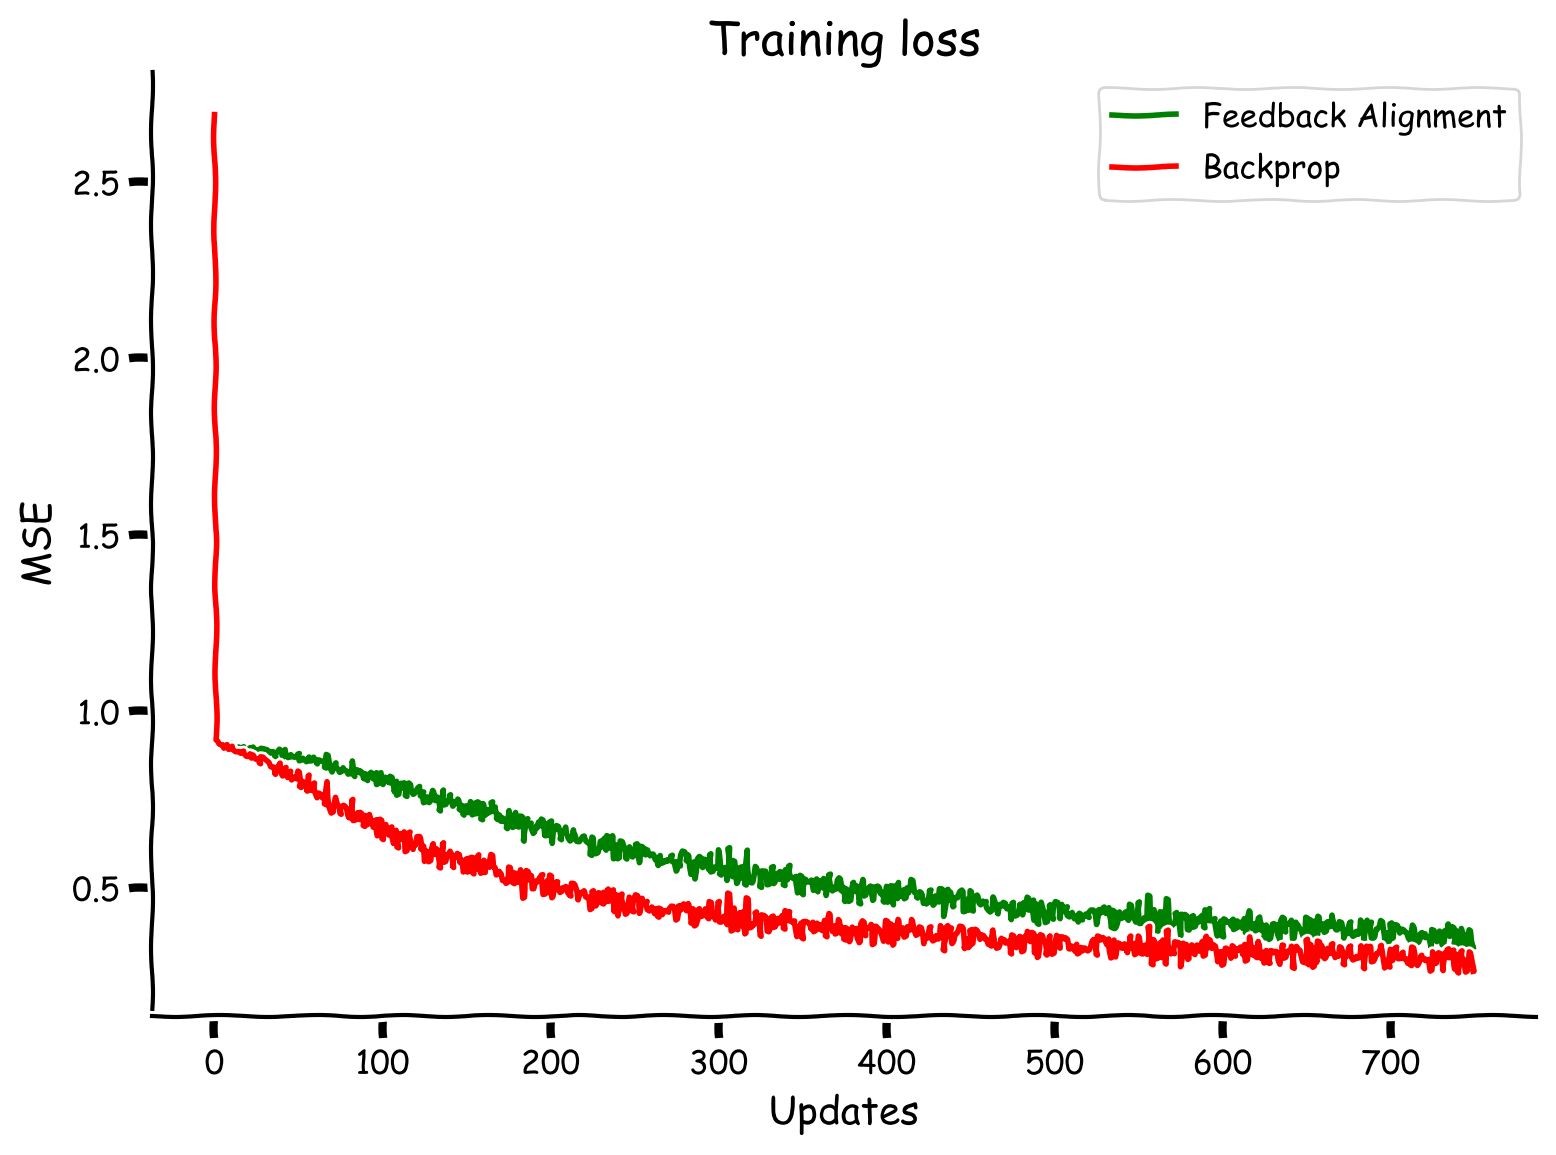

In [58]:
# @title Train and observe the performance of FeedbackAlignmentMLP

rng_fa = np.random.default_rng(seed=seed)

losses_feedback = np.zeros((numupdates,))
accuracy_feedback = np.zeros((numepochs,))
cosine_sim_feedback = np.zeros((numepochs,))

# select 1000 random images to test the accuracy on
indices = rng_fa.choice(range(test_images.shape[1]), size=(1000,), replace=False)

# create a network and train it using feedback alignment
netfeedback = FeedbackAlignmentMLP(rng_fa, numhidden, sigma=initweight, activation=activation)
(losses_feedback[:], accuracy_feedback[:], cosine_sim_feedback[:], _) = \
    netfeedback.train(rng_fa, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=learnrate, batch_size=batchsize, algorithm='feedback', noise=noise, \
                      report=report, report_rate=rep_rate)

# Train a network with Backpropagation for comparison

# set the random seed to the current time
rng_bp2 = np.random.default_rng(seed=seed)

# select 1000 random images to test the accuracy on
indices = rng_bp2.choice(range(test_images.shape[1]), size=(1000,), replace=False)

losses_backprop = np.zeros((numupdates,))
accuracy_backprop = np.zeros((numepochs,))
cosine_sim_backprop = np.zeros((numepochs,))

# create a network and train it using backprop
netbackprop = MLP(rng_bp2, numhidden, sigma=initweight, activation=activation)
(losses_backprop[:], accuracy_backprop[:], cosine_sim_backprop, _) = \
    netbackprop.train(rng_bp2, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=learnrate, batch_size=batchsize, algorithm='backprop', noise=noise, \
                      report=report, report_rate=rep_rate)

# plot performance over time
with plt.xkcd():
    plt.plot(losses_data['feedback_alignment'], label="Feedback Alignment", color='g') #pre-saved history of loss
    plt.plot(losses_data['backpropagation'], label="Backprop", color='r') #pre-saved history of loss
    plt.xlabel("Updates")
    plt.ylabel("MSE")
    plt.legend()
    plt.title("Training loss")
    plt.show()

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_feedback_alignment")

---
# Section 5: Kolen-Pollack

Estimated timing to here from start of tutorial: 1 hour 20 minutes

This section presents the last method for this day, which lies in the cohort of biased ones, Kolen-Pollack method.

In [ ]:
# @title Video 4: Kolen-Pollack

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'T1K8lL7XYEY'), ('Bilibili', 'BV16y411B7qm')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_video_4")



$\newcommand{\error}{\boldsymbol \delta}$
$\newcommand{\losserror}{\mathbf{e}}$
$\newcommand{\backweight}{\mathbf{B}}$
$\newcommand{\h}{\mathbf{h}}$
$\newcommand{\y}{\mathbf{y}}$


As we've just seen, to update a feed-forward matrix using back-propagated error, we need to simply follow the weight update equation:
\begin{align}
    %\Delta \weight_{ji} &= - \eta \delta_j h^{\prime}_j\stim_i \\
    \Delta \weight_{out} &= - \eta \losserror \h^T \\
    \Delta \weight &= - \eta (\error \h^{\prime})\stim^T,
\end{align}
where
\begin{align}
    \error &= \weight_{out}^T \losserror .
\end{align}
While directly "transporting" the weights, $\weight_{out}^T$, is not biologically plausible, we showed that a random feedback matrix, $\backweight$, can align the weights to propagate an approximated error,
\begin{align}
    \error &= \backweight \losserror .
\end{align}

However, this approach fails with deeper networks and more complicated datasets. We will now show a biologically plausible approach to modifying $\backweight$, such that over learning, $\backweight$ and $ \weight_{out}^T $ become equal. This approach builds off an observation by Kolen and Pollack (1994) that if two matrices are repeatedly modified by the same values with weight decay,

\begin{align}
    \Delta \weight(t) &= \mathbf{A}(t) - \lambda \weight(t) \\
    \Delta \backweight(t) &= \mathbf{A}(t) - \lambda \backweight(t) ,
\end{align}
then
\begin{align}
    \weight(t+1) - \backweight(t+1) &= \weight(t) + \Delta \weight(t) - \backweight(t) - \Delta \backweight(t) \\
    &= \weight(t) - \backweight(t) - \lambda[\weight(t) - \backweight(t)] \\
    &= (1-\lambda)^{t+1} [\weight(0) - \backweight(0)] .
\end{align}
That is, as $t \rightarrow \infty$, the difference between the two matrices will converge to 0.

The key observation is that the corresponding elements of $\weight_{out}^T$ and $ \backweight $ have access to the same locally available information. We can thus pick a plausible learning rule for the backward weights:

\begin{align}
    \Delta \backweight &= - \eta \h \losserror^T - \lambda \backweight ,
\end{align}
such that the updates to $\backweight$ correspond to a transpose of the updates to $\weight_{out}$,
\begin{align}
    \Delta \weight_{out} &= - \eta \losserror \h^T - \lambda \weight_{out} \\
    \Delta \weight_{out}^T &= - \eta \h \losserror^T - \lambda \weight_{out}^T.
\end{align}

Thus, over many weight updates, $ \backweight $ will converge to $\weight_{out}^T$ and can be used to propagate errors back to inform updates to $\weight$. Note that the same reasoning can be applied to networks of many layers.

## Exercise 3: Kolen-Pollack algorithm

For this exercise, you will be implementing the Kolen-Pollack algorithm for our MLP network. Fill in the proper gradient calculation below.

In [ ]:
class KolenPollackMLP(MLP):
    """
    A multilayer perceptron that is capable of learning through the Kolen-Pollack algorithm
    """

    def kolepoll(self, rng, inputs, targets, eta_back=0.01):
        """
        Calculates the weight updates for Kolen-Polack learning
        """
        ###################################################################
        ## Fill out the following then remove
        raise NotImplementedError("Student exercise: calculate updates.")
        ###################################################################

        # do a forward pass
        (hidden, output) = self.inference(rng, inputs)

        # calculate the updates for the forward weights
        error = targets - output
        delta_W_h = np.dot(np.dot(self.B, error * self.act_deriv(output)) * self.act_deriv(hidden), \
                           add_bias(inputs).transpose())
        delta_err = ...
        delta_W_y = delta_err - 0.1 * self.W_y

        # calculate the updates for the backwards weights and implement them
        delta_B = delta_err[:, :-1].transpose() - 0.1 * self.B
        self.B += ...
        return (delta_W_h, delta_W_y)

In [16]:
# to_remove solution

class KolenPollackMLP(MLP):
    """
    A multilayer perceptron that is capable of learning through the Kolen-Pollack algorithm
    """

    def kolepoll(self, rng, inputs, targets, eta_back=0.01):
        """
        Calculates the weight updates for Kolen-Polack learning
        """

        # do a forward pass
        (hidden, output) = self.inference(rng, inputs)

        # calculate the updates for the forward weights
        error = targets - output
        delta_W_h = np.dot(np.dot(self.B, error * self.act_deriv(output)) * self.act_deriv(hidden), \
                           add_bias(inputs).transpose())
        delta_err = np.dot(error * self.act_deriv(output), add_bias(hidden).transpose())
        delta_W_y = delta_err - 0.1 * self.W_y

        # calculate the updates for the backwards weights and implement them
        delta_B = delta_err[:, :-1].transpose() - 0.1 * self.B
        self.B += eta_back * delta_B
        return (delta_W_h, delta_W_y)

Now that you have implemented Kolen-Pollack, we will test that it works by training a sample MLP network.

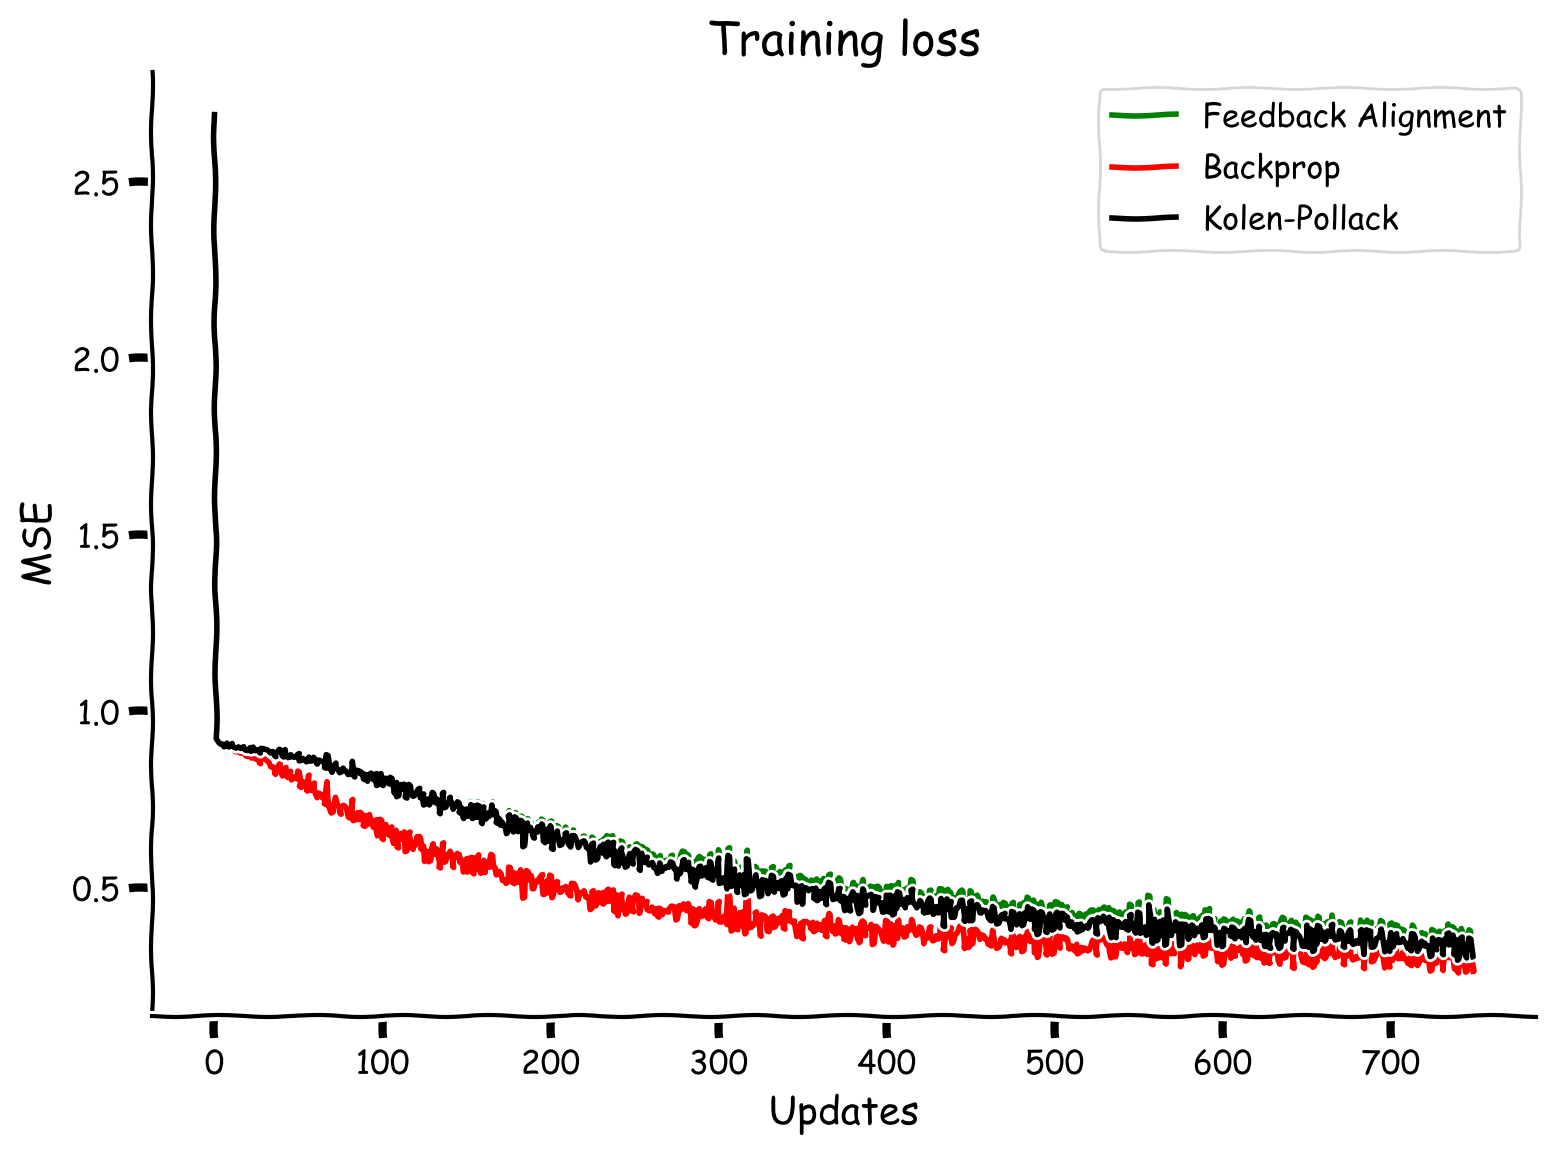

In [59]:
# @title Train and observe the performance of KolenPollackMLP
rng_kp = np.random.default_rng(seed=seed)

losses_kolepoll = np.zeros((numupdates,))
accuracy_kolepoll = np.zeros((numepochs,))
cosine_sim_kolepoll = np.zeros((numepochs,))
# select 1000 random images to test the accuracy on
indices = rng_kp.choice(range(test_images.shape[1]), size=(1000,), replace=False)

# create a network and train it using feedback alignment
netkolepoll = KolenPollackMLP(rng_kp, numhidden, sigma=initweight, activation=activation)
(losses_kolepoll[:], accuracy_kolepoll[:], cosine_sim_kolepoll[:], _) = \
    netkolepoll.train(rng_kp, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=learnrate, batch_size=batchsize, algorithm='kolepoll', noise=noise, \
                      report=report, report_rate=rep_rate)

# plot performance over time
with plt.xkcd():
    plt.plot(losses_data['feedback_alignment'], label="Feedback Alignment", color='g') #pre-saved history of loss
    plt.plot(losses_data['backpropagation'], label="Backprop", color='r') #pre-saved history of loss
    plt.plot(losses_data['kolen_pollack'], label="Kolen-Pollack", color='k') #pre-saved history of loss
    plt.xlabel("Updates")
    plt.ylabel("MSE")
    plt.legend()
    plt.title("Training loss")
    plt.show()

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_kolen_pollack")

---
# Section 6: Assessing the bias of learning algorithms

Estimated timing to here from start of tutorial: 1 hour 50 minutes


Having implemented both Feedback Alignment and Kolen-Pollack, we should now compare the parameter updates obtained by these algorithms to the Backpropagation update itself, so that we can assess how accurate these methods actually are.

To do this, we will measure the alignment between two gradient estimates using the *cosine similarity*, which is defined as follows, for two proposed parameter updates $\Delta \theta_1$ and $\Delta \theta_2$, which we assume are vectors of equal length:

\begin{equation}
CSim(\Delta \theta_1, \Delta \theta_2) = \frac{\Delta \theta_1^T \Delta \theta_2}{\|\Delta \theta_1\|_2 \| \Delta \theta_2 \|_2},
\end{equation}

This is simply the inner product between a unit vector pointing in the direction of $\Delta \theta_1$ and a unit vector pointing in the direction of $\Delta \theta_2$. It takes value 1 if the two vectors are perfectly aligned, 0 if they are orthogonal, and -1 if they point in the exact opposite direction from one another. Like the SNR, the cosine similarity measure is also *scale invariant*, so multiplying $\Delta \theta_1$ by a constant (e.g. a learning rate) will not change the cosine similarity at all. We care about parameter updates pointing in the same *direction* as the gradient, but for our purposes, it does not really matter if the update is greater or lesser in magnitude, because we can always decrease or increase the learning rate. For this reason, using a scale invariant measure of alignment is advantageous, because it ignores magnitudes.

Below, we show the cosine similarity between backpropagation, feedback alignment, and Kolen-Pollack, all compared to the backpropagation algorithm itself. The backpropagation-to-backpropagation cosine similarity will always be 1, because the vectors trivially point in the same direction.

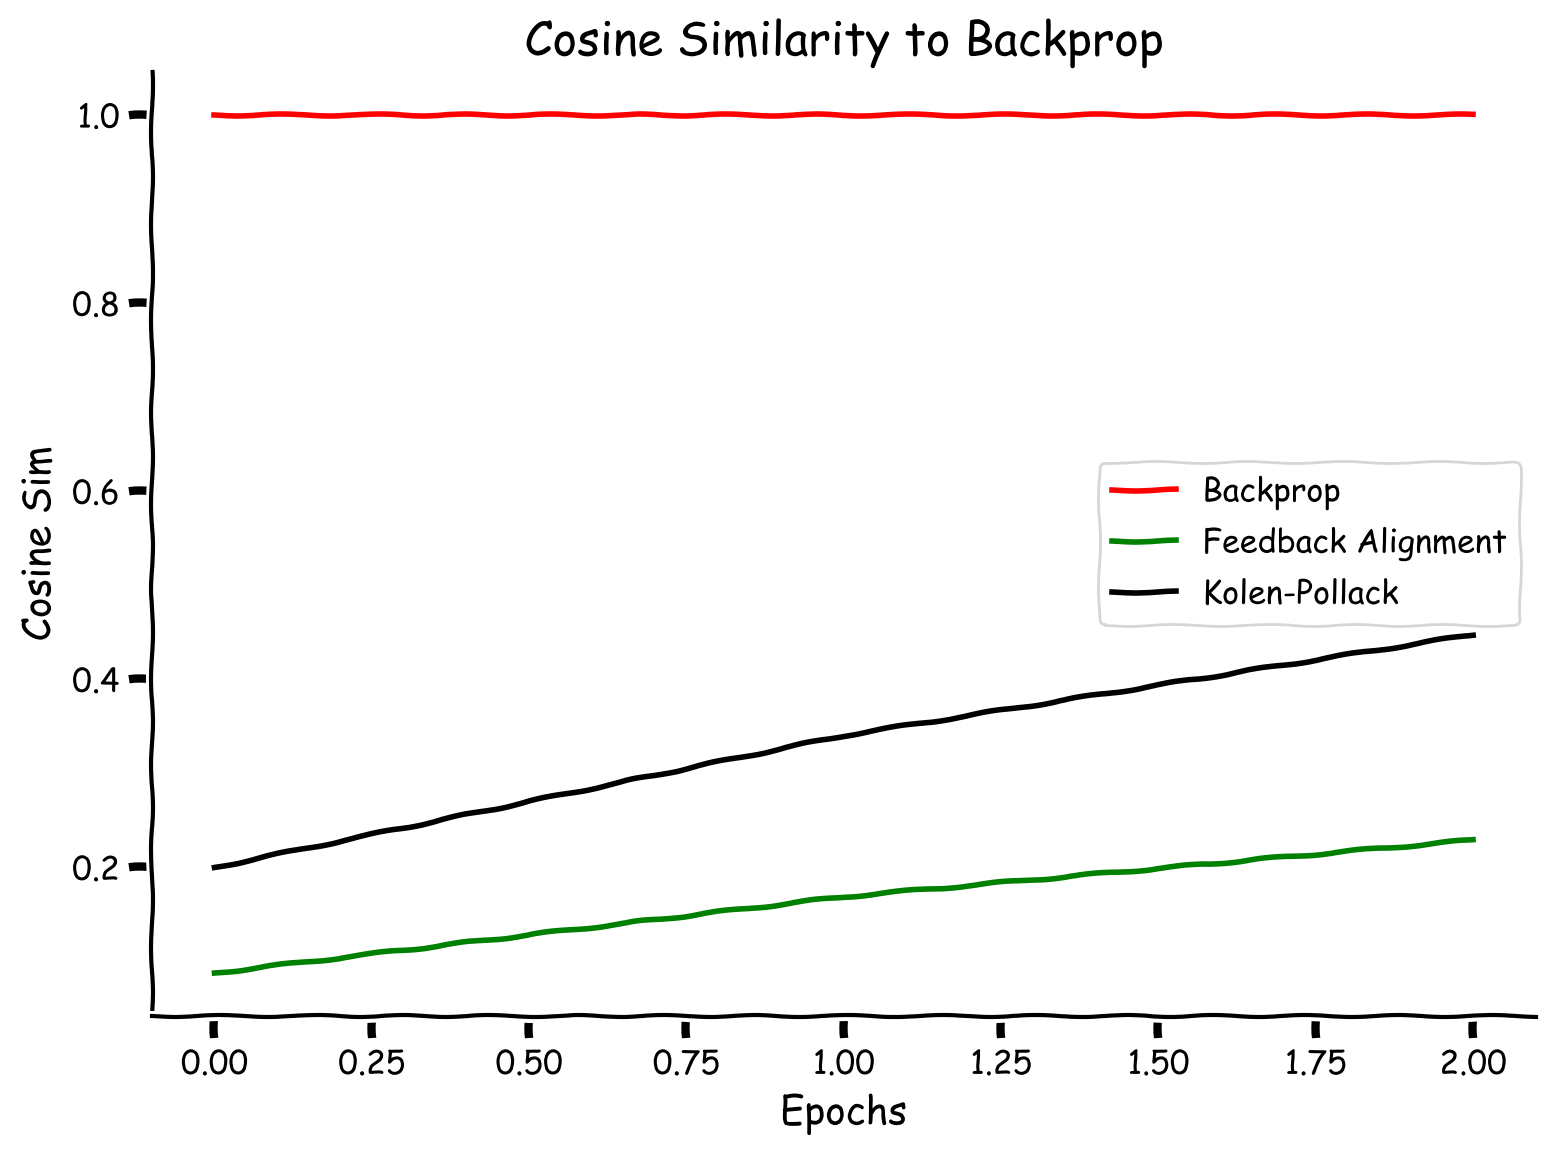

In [60]:
# @title Plot the gradient similarity to backprop over training with shaded error regions
with plt.xkcd():
    plt.plot(cosine_similarity_data["backpropagation"], label="Backprop", color='r')
    plt.plot(cosine_similarity_data["feedback_alignment"], label="Feedback Alignment", color='g')
    plt.plot(cosine_similarity_data["kolen_pollack"], label="Kolen-Pollack", color='k')
    plt.xlabel("Epochs")
    plt.ylabel("Cosine Sim")
    plt.legend()
    plt.title("Cosine Similarity to Backprop")
    plt.show()

Finally, let's show that these improvements in the alignment between the backprop gradient estimates and the various local estimates correlate with the accuracy of the classification on MNIST.

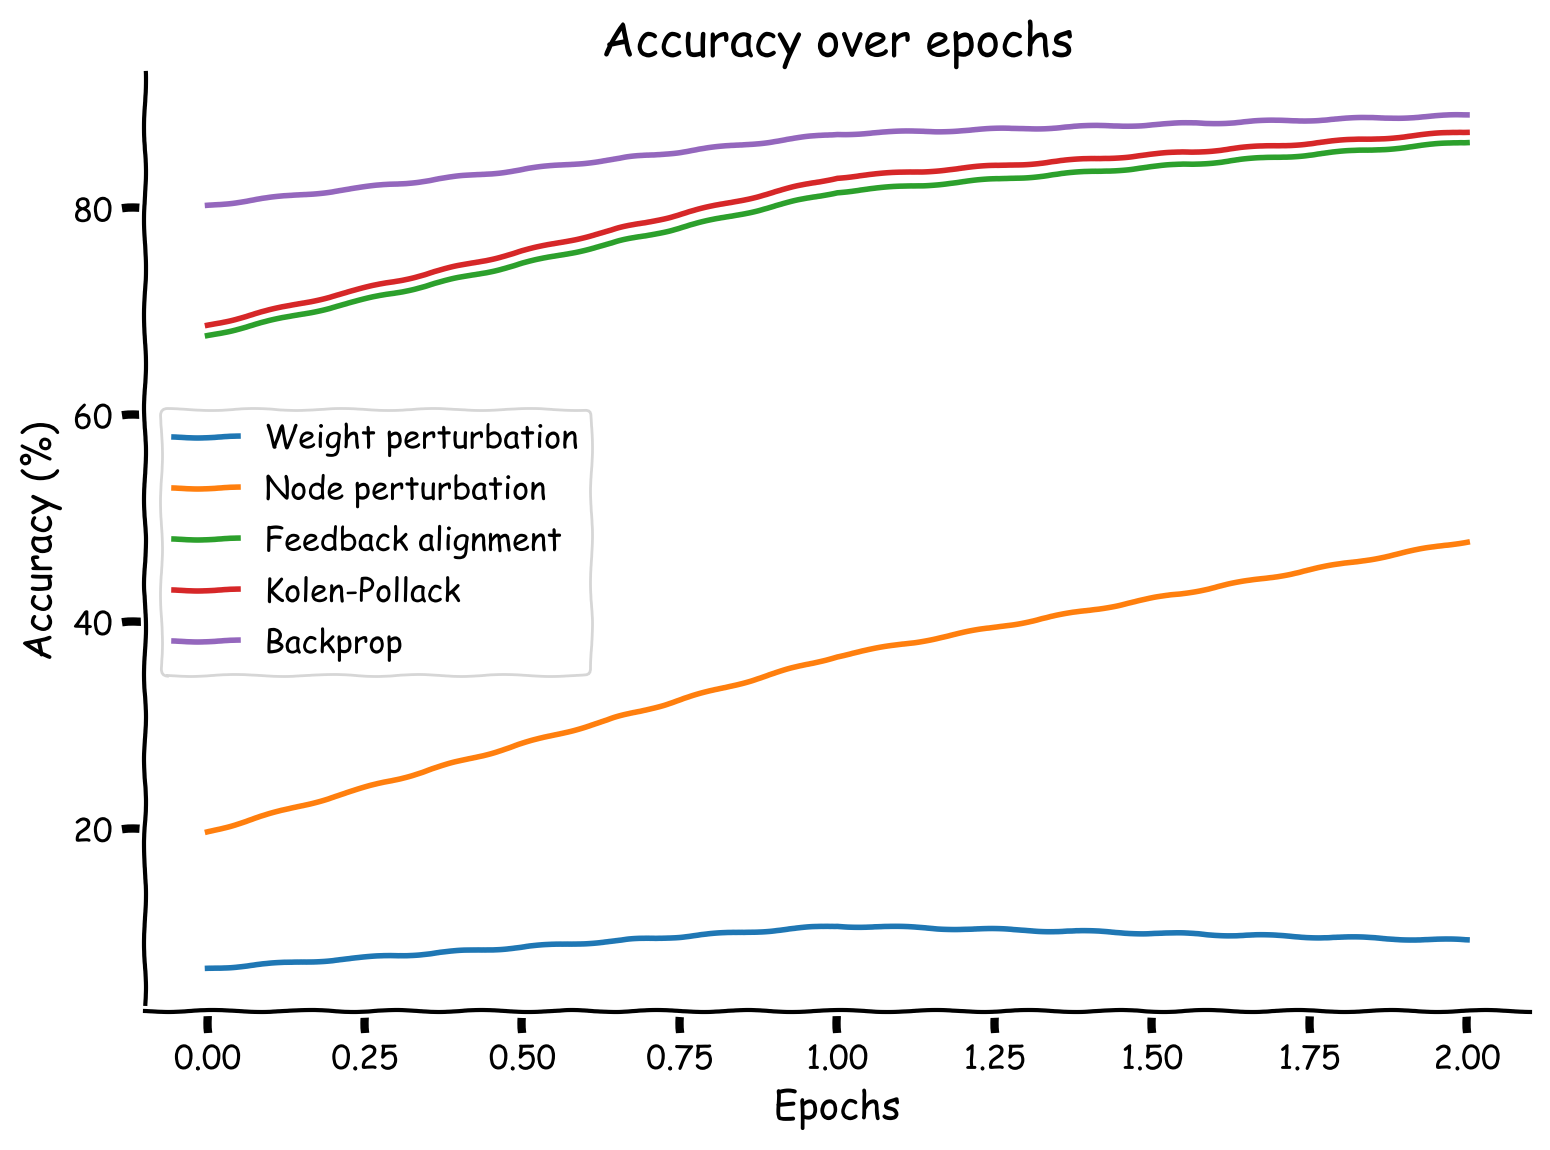

In [19]:
# @title Classification accuracy comparison
with plt.xkcd():
    plt.plot(accuracy_perturb)
    plt.plot(accuracy_node_perturb)
    plt.plot(accuracy_feedback)
    plt.plot(accuracy_kolepoll)
    plt.plot(accuracy_backprop)
    plt.legend(['Weight perturbation', 'Node perturbation', 'Feedback alignment', 'Kolen-Pollack', 'Backprop'])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy over epochs')

In [26]:
#to save in data files
import pandas as pd
accuracy_df = pd.DataFrame(columns = ["weight_perturbation", "node_perturbation", "feedback_alignment", "kolen_pollack", "backpropagation"])

accuracy_df["weight_perturbation"] = accuracy_perturb
accuracy_df["node_perturbation"] = accuracy_node_perturb
accuracy_df["feedback_alignment"] = accuracy_feedback
accuracy_df["kolen_pollack"] = accuracy_kolepoll
accuracy_df["backpropagation"] = accuracy_backprop

accuracy_df.to_csv("accuracy.csv", index = False)

In [27]:
cosine_sim_backprop.shape

(3,)

In [29]:
#to save in data files
import pandas as pd
cosine_similarity_df = pd.DataFrame(columns = ["feedback_alignment", "kolen_pollack", "backpropagation"])

cosine_similarity_df["feedback_alignment"] = cosine_sim_feedback
cosine_similarity_df["kolen_pollack"] = cosine_sim_kolepoll
cosine_similarity_df["backpropagation"] = cosine_sim_backprop

cosine_similarity_df.to_csv("cosine_similarity.csv", index = False)

In [50]:
#to save in data files
import pandas as pd
snr_df = pd.DataFrame(columns = ["weight_perturbation", "node_perturbation", "backpropagation"])

snr_df["weight_perturbation"] = [snr_perturb]
snr_df["node_perturbation"] = [snr_node_perturb]
snr_df["backpropagation"] = [snr_backprop]

snr_df.to_csv("snr.csv", index = False)

In [ ]:
#to save in data files
import pandas as pd
snr_df = pd.DataFrame(columns = ["weight_perturbation", "node_perturbation", "backpropagation"])

snr_df["weight_perturbation"] = snr_perturb
snr_df["node_perturbation"] = snr_node_perturb
snr_df["backpropagation"] = snr_backprop

snr_df.to_csv("snr.csv", index = False)

In [32]:
losses_kolepoll.shape

(750,)

In [33]:
#to save in data files
import pandas as pd
losses_df = pd.DataFrame(columns = ["weight_perturbation", "node_perturbation", "feedback_alignment", "kolen_pollack", "backpropagation"])

losses_df["weight_perturbation"] = losses_perturb
losses_df["node_perturbation"] = losses_node_perturb
losses_df["feedback_alignment"] = losses_feedback
losses_df["kolen_pollack"] = losses_kolepoll
losses_df["backpropagation"] = losses_backprop

losses_df.to_csv("losses.csv", index = False)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_assessing_bias")

---
# Summary

*Estimated timing of tutorial: 2 hours*

Here, we will end the tutorial with a few final remarks:
* There are many learning algorithms that are capable of optimizing system-wide objective functions using only information that could be plausibly available to a synapse (e.g. weight and node perturbation, feedback alignment, and Kolen-Pollack).
* Local learning algorithms typically either introduce high variance or biases into gradient estimates.
* Bias and variance in gradient estimates can impede the ability of a neural system to learn effectively at scale, either on complex datasets or in large neural networks.
* Therefore, good generalization (which depends on large, powerful network architectures), will come from learning algorithms that have as little variance and bias in their gradient estimates as possible.
* The neuroscience community does not yet know which, if any, of the learning algorithms discussed in this tutorial map onto learning in the brain. The algorithms we have introduced are best thought of as 'candidate models' for how the brain could be learning.